In [2]:
import re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import networkx as nx

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD

np.random.seed(42)

In [3]:
df = pd.read_excel('data/final_risk_data.xlsx')

# изменение типов данных
df['date'] = pd.to_datetime(df['date']).dt.normalize()
for i in ['debit_amount', 'credit_amount']:
    if i in df.columns:
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
# создание колонки с суммой операции
df["amount"] = np.where(df["debit_amount"].notna(), df["debit_amount"], df["credit_amount"])
df["debit_amount"] = df["debit_amount"].fillna(0.0)
df["credit_amount"] = df["credit_amount"].fillna(0.0)

# созжание временных признаков
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['month'] = df['date'].dt.month
df["weekofyear"]   = df["date"].dt.isocalendar().week.astype(int)

# Суточные фичи
df['daily_total_debit'] = df.groupby(['debit_inn', 'date'])['debit_amount'].transform('sum')
df['daily_total_credit'] = df.groupby(['credit_inn', 'date'])['credit_amount'].transform('sum')
# посчет транзакций за сутки
df["daily_debit_transaction_count"]    = df.groupby(["debit_inn","date"])["debit_amount"].transform(lambda s: (s > 0).sum())
df["daily_credit_transaction_count"]    = df.groupby(["credit_inn","date"])["credit_amount"].transform(lambda s: (s > 0).sum())
# уникальные отправители и получатели в сутки
df["unique_recipients_per_day"] = df.groupby(["debit_inn","date"])["credit_inn"].transform("nunique")
df["unique_receivers_per_day"] = df.groupby(["credit_inn","date"])["debit_inn"].transform("nunique")

# Доля текущей операции в суточном объёме
df["daily_debit_percent"] = (df["debit_amount"] / df["daily_total_debit"].replace(0, np.nan)).fillna(0.0)
df["daily_credit_percent"] = (df["credit_amount"] / df["daily_total_credit"].replace(0, np.nan)).fillna(0.0)

# Интервалы между операциями (в днях)
df["days_since_last_txn_debit"]  = df.groupby("debit_inn")["date"].diff().dt.days.fillna(9999)
df["days_since_last_txn_credit"] = df.groupby("credit_inn")["date"].diff().dt.days.fillna(9999)

def add_rolling_side(df: pd.DataFrame,
                     side: str,
                     amt_col: str,
                     windows=(7, 14, 30, 90)) -> pd.DataFrame:
    """
    Создает роллинги по суммам/кол-ву транзакций за окна windows для заданной стороны.
    side: 'debit' или 'credit'
    amt_col: имя столбца с суммой для этой стороны (например, 'debit_amount' / 'credit_amount')
    """
    inn_col = f"{side}_inn"
    out_parts = []

    # Берем только нужные колонки (ускоряет groupby)
    need_cols = [inn_col, "date", amt_col]
    sub_all = df[need_cols].copy()
    sub_all[amt_col] = sub_all[amt_col].fillna(0.0)

    for inn, sub in sub_all.groupby(inn_col, sort=False):
        # суточная агрегация по аккаунту
        daily = (sub.groupby("date", as_index=True)[amt_col]
                   .sum()
                   .to_frame("amt_day")
                   .sort_index())

        # непрерывный календарный индекс (чтобы окна не "сжимались")
        idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
        daily = daily.reindex(idx, fill_value=0.0)
        daily.index.name = "date"

        # индикатор "была ли операция в день" (для роллинга количества)
        daily["tx_day"] = (daily["amt_day"] > 0).astype(int)

        # роллинги
        for W in windows:
            daily[f"{side}_roll_sum_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_cnt_{W}d"]  = daily["tx_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_mean_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).mean()
            daily[f"{side}_roll_std_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).std().fillna(0.0)
            daily[f"{side}_roll_p95_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).quantile(0.95)

        daily = daily.reset_index()
        daily[inn_col] = inn
        out_parts.append(daily[["date", inn_col] + [c for c in daily.columns if c.startswith(f"{side}_roll_")]])

    rolls = pd.concat(out_parts, ignore_index=True)
    return df.merge(rolls, on=["date", inn_col], how="left")



# Новые роллинги 7/14/30/90 для дебета и кредита
WINDOWS = (7, 14, 30, 90)
df = add_rolling_side(df, side="debit",  amt_col="debit_amount",  windows=WINDOWS)
df = add_rolling_side(df, side="credit", amt_col="credit_amount", windows=WINDOWS)

# ==== 1. Всплески сумм (amount_spike_ratio_7d) ====
df["debit_amount_spike_ratio_7d"]  = df["debit_roll_sum_7d"]  / (df["debit_roll_sum_30d"]/4 + 1e-6)
df["credit_amount_spike_ratio_7d"] = df["credit_roll_sum_7d"] / (df["credit_roll_sum_30d"]/4 + 1e-6)

# ==== 2. Всплески активности (tx_rate_spike_7d) ====
df["debit_tx_rate_spike_7d"]  = df["debit_roll_cnt_7d"]  / (df["debit_roll_cnt_30d"]/4 + 1e-6)
df["credit_tx_rate_spike_7d"] = df["credit_roll_cnt_7d"] / (df["credit_roll_cnt_30d"]/4 + 1e-6)

# ==== 3. Fan-out / Fan-in (уникальные контрагенты) ====
# Для дебета — fan-out (сколько разных получателей на операцию)
df["debit_fan_out_ratio"] = df["unique_recipients_per_day"] / (df["daily_debit_transaction_count"] + 1e-6)

# Для кредита — fan-in (сколько разных отправителей на операцию)
df["credit_fan_in_ratio"] = (
    df.groupby(["credit_inn", "date"])["debit_inn"].transform("nunique") /
    (df["daily_credit_transaction_count"] + 1e-6)
)

# ==== 4. Дисбаланс потоков (in_out_ratio_30d) ====
df["in_out_ratio_30d"] = (df["credit_roll_sum_30d"] + 1e-6) / (df["debit_roll_sum_30d"] + 1e-6)

# ==== 5. Волатильность объёмов (amount_volatility_30d) ====
df["debit_amount_volatility_30d"]  = df["debit_roll_std_30d"]  / (df["debit_roll_mean_30d"]  + 1e-6)
df["credit_amount_volatility_30d"] = df["credit_roll_std_30d"] / (df["credit_roll_mean_30d"] + 1e-6)


# Круглые суммы
df["round_10k"]  = ((df["amount"] % 10000)  == 0).astype(int)
df["round_100k"] = ((df["amount"] % 100000) == 0).astype(int)
df["round_large_amount"] = ((df["round_10k"]==1) | (df["round_100k"]==1)).astype(int)

df.head()



,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,debit_tx_rate_spike_7d,credit_tx_rate_spike_7d,debit_fan_out_ratio,credit_fan_in_ratio,in_out_ratio_30d,debit_amount_volatility_30d,credit_amount_volatility_30d,round_10k,round_100k,round_large_amount
0,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,3.999984,0.000000,1.0,1000000.0,3.333322e-13,0.000000,0.0,0,0,0
1,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,3.999984,0.000000,1.0,1000000.0,3.333322e-13,0.000000,0.0,1,1,1
2,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,3.999992,0.000000,1.0,1000000.0,3.328560e-13,1.410173,0.0,0,0,0
3,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,e63cf19b76230a3d,21a73421ca00ae87,eed8b1f54ed4366c,4282.0,0.0,оплата по договору электроэнергия по дог.№1124...,...,3.999992,0.000000,1.0,1000000.0,3.328560e-13,1.410173,0.0,0,0,0
4,2019-01-10,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1000000.0,перевод денежных средств по договору займа № ч...,...,0.000000,3.999984,1000000.0,1.0,3.000000e+12,0.000000,0.0,1,1,1


In [4]:
# ============================================================
#  Анализ "Назначения платежа": TF-IDF (char 3–5) + стоп-слова риска
# ============================================================

import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# ------------------------------------------------------------
# 1) Регулярные паттерны высокого риска
# ------------------------------------------------------------
STOP_HIGH_PATTERNS = [
    r"\bзайм\w*\b", r"\bвозврат\W*(займ|долг)\w*\b", r"\bпогашен\w*\W*(займ|долг)\w*\b",
    r"\bдолг\w*\b", r"\bоплат\w*\W*(займ|долг)\w*\b",
    r"\bкрипт\w*\b", r"\bбиткоин\w*\b", r"\busdt\b", r"\bbtc\b", r"\bcoin\b",
    r"\bбирж\w*\b", r"\bобмен\w*\b", r"\bвалют\w*\b",
    r"\bналич\w*\b", r"\bобнал\w*\b", r"\bвыдач\w*\W*налич\w*\b",
    r"\bперевод\w*\W*(на|с)\W*карт\w*\b", r"\bперевод\w*\W*физ\w*\b",
    r"\bперевод\w*\W*родствен\w*\б", r"\bперевод\w*\W*средств\b",
    r"\bбез\W*договор\w*\b",
    r"\bпожертв\w*\b", r"\bблаготвор\w*\б", r"\bдарен\w*\b",
    r"\bагентск\w*\W*вознагражд\w*\б",
    # r"\bкомисси\w*\W*вознагражд\w*\b",
    r"\bвознагражд\w*\b",
    r"\bцесс\w*\б", r"\bпоручител\w*\b", r"\bзалог\w*\b",
    r"\bофшор\w*\б", r"\bиностран\w*\W*перевод\w*\b", r"\bswift\b",
    r"\bличн\w*\W*нужд\w*\б", r"\bпередач\w*\W*актив\w*\б",
    r"\bвклад\w*\б", r"\bдепозит\w*\б",
]
STOP_HIGH_RE = re.compile("|".join(STOP_HIGH_PATTERNS), flags=re.IGNORECASE)

# ------------------------------------------------------------
# 2) Очистка текста
# ------------------------------------------------------------
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-zа-я0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["purpose_clean"] = df["purpose"].apply(clean_text)

# ------------------------------------------------------------
# 3) Метка наличия стоп-слов риска
# ------------------------------------------------------------
df["purpose_stopword_high"] = df["purpose_clean"].str.contains(STOP_HIGH_RE, na=False)

# ------------------------------------------------------------
# 4) TF-IDF (char-level 3–5-граммы) + SVD
# ------------------------------------------------------------
texts = df["purpose_clean"].astype(str).tolist()

tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=1
)
X_tfidf = tfidf.fit_transform(texts)
print(f"TF-IDF матрица: {X_tfidf.shape[0]} × {X_tfidf.shape[1]}")

# SVD для сжатия (например, до 50 компонент)
svd_k_target = 50
max_svd = max(1, min(X_tfidf.shape[0] - 1, X_tfidf.shape[1] - 1))
n_svd = min(svd_k_target, max_svd)

svd = TruncatedSVD(n_components=n_svd, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

for i in range(X_svd.shape[1]):
    df[f"purpose_svd_{i+1}"] = X_svd[:, i]

expl_var = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance (k={X_svd.shape[1]}): {expl_var:.3f}")

# ------------------------------------------------------------
# 5) Результат
# ------------------------------------------------------------
svd_cols = [c for c in df.columns if c.startswith("purpose_svd_")]
cols_show = ["purpose", "purpose_stopword_high"] + svd_cols

print(f"\n Добавлены признаки: {len(svd_cols)} SVD-компонент + метка стоп-слов")
print(df[cols_show].head())


TF-IDF матрица: 2688 × 45426
SVD explained variance (k=50): 0.545

 Добавлены признаки: 50 SVD-компонент + метка стоп-слов
                                             purpose  purpose_stopword_high  \
0  комиссия внутри сбербанка за пп/пт через дбо с...                  False   
1  оплата по счету № 28 от date_9f241b636025 по д...                  False   
2  комиссия внутри сбербанка за пп/пт через дбо с...                  False   
3  оплата по договору электроэнергия по дог.№1124...                  False   
4  перевод денежных средств по договору займа № ч...                   True   

   purpose_svd_1  purpose_svd_2  purpose_svd_3  purpose_svd_4  purpose_svd_5  \
0       0.708416      -0.202923      -0.110215      -0.029243       0.142140   
1       0.122677       0.236405      -0.200400      -0.017372      -0.097021   
2       0.602413      -0.212909      -0.103785      -0.020422       0.124845   
3       0.108051       0.160672      -0.135616      -0.000770      -0.035201   
4 

In [4]:
df.columns

Index(['date', 'debit_account', 'debit_name', 'debit_inn', 'credit_account',
       'credit_name', 'credit_inn', 'debit_amount', 'credit_amount', 'purpose',
       ...
       'purpose_svd_41', 'purpose_svd_42', 'purpose_svd_43', 'purpose_svd_44',
       'purpose_svd_45', 'purpose_svd_46', 'purpose_svd_47', 'purpose_svd_48',
       'purpose_svd_49', 'purpose_svd_50'],
      dtype='object', length=130)

Всего строк в длинной таблице: 5,376
ИНН с >= 30 транзакциями (суммарно дебет+кредит): 16


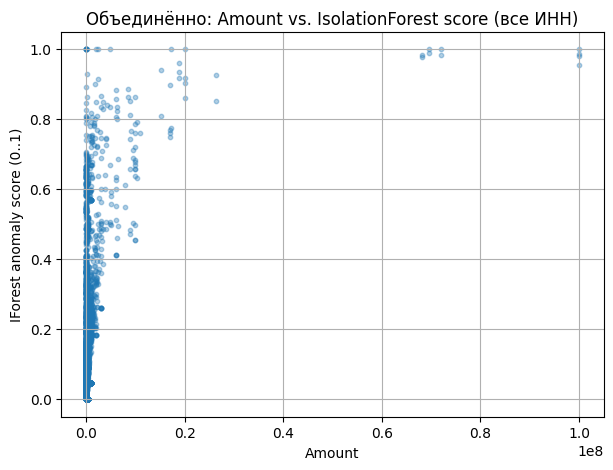

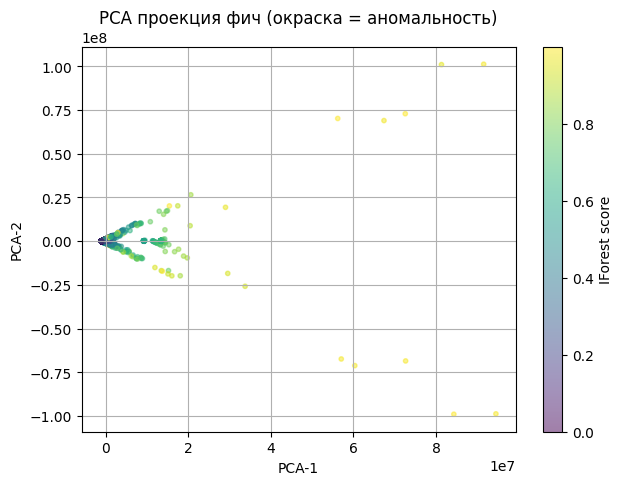

,txn_id,date,inn,side,amount,signed_amount,purpose,iforest_score
1899,NaN,2021-07-06,8d9e0be733f77f1c,debit,1.000000e+08,-1.000000e+08,выдача кредита по договору n600210017 от 24 ию...,1.000000
4633,NaN,2021-07-09,6931e23e98703aa9,credit,6.950000e+07,6.950000e+07,окончательная оплата по счету №9 от date_aaac9...,1.000000
5196,NaN,2022-08-02,1b21a7645f64d170,credit,4.869204e+06,4.869204e+06,по решению о взыскании № 5593 от date_11c36260...,1.000000
1886,NaN,2021-06-30,80799e1a6646b6dc,debit,1.729715e+07,-1.729715e+07,"acc_cd27e0d43c60;ст. 176 нк рф, год: 2021 реше...",1.000000
4853,NaN,2021-10-22,6290b8d67943ece5,credit,1.686064e+04,1.686064e+04,расчет уволнение 21г для зачисления на счет та...,1.000000
...,...,...,...,...,...,...,...,...
0,NaN,2019-01-09,d877722ca4e40f98,debit,1.000000e+01,-1.000000e+01,комиссия внутри сбербанка за пп/пт через дбо с...,0.739824
4743,NaN,2021-08-30,8d9e0be733f77f1c,credit,1.261912e+06,1.261912e+06,погашение задолженности по договору n 60021001...,0.738533
4866,NaN,2021-10-28,8d9e0be733f77f1c,credit,1.221205e+06,1.221205e+06,погашение задолженности по договору n 60021001...,0.735682
1438,NaN,2021-01-18,5ae9eeb0d29bc5c0,debit,1.000000e+06,-1.000000e+06,перевод денежных средств по договору № пи-1/28...,0.734101


 Сохранено: top100_anomalous_txn_combined.csv


In [82]:
# === Ячейка 1. Поведение одного и того же ИНН с объединением дебета и кредита ===
# Требования: df c колонками как минимум:
# ['id','date','amount','purpose','debit_inn','credit_inn',
#  'debit_roll_cnt_30d','debit_roll_mean_30d','debit_roll_std_30d',
#  'debit_amount_spike_ratio_7d','debit_tx_rate_spike_7d','debit_amount_volatility_30d',
#  'credit_roll_cnt_30d','credit_roll_mean_30d','credit_roll_std_30d',
#  'credit_amount_spike_ratio_7d','credit_tx_rate_spike_7d','credit_amount_volatility_30d']
# Если каких-то признаков нет — они будут заполнены нулями.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 30

# -------- 0) Подготовка длинной таблицы "персона-операция" --------
# Создадим две проекции: взгляд со стороны дебета и со стороны кредита,
# унифицируя имена фич под "side_*", а также признак signed_amount (- для дебета, + для кредита).

need_cols_deb = [
    "id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
need_cols_cred = [
    "id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]

for c in need_cols_deb:
    if c not in df.columns: df[c] = 0.0 if c!="purpose" and c!="date" and c!="id" and c!="debit_inn" else df.get(c, np.nan)
for c in need_cols_cred:
    if c not in df.columns: df[c] = 0.0 if c!="purpose" and c!="date" and c!="id" and c!="credit_inn" else df.get(c, np.nan)

deb_view = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "signed_amount": -df["amount"].astype(float),  # отток
    "side_roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "side_roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "side_roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "side_amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "side_tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "side_amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

cred_view = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "signed_amount": df["amount"].astype(float),   # приток
    "side_roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "side_roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "side_roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "side_amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "side_tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "side_amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

df_long = pd.concat([deb_view, cred_view], axis=0, ignore_index=True)
df_long = df_long.dropna(subset=["inn"])  # убираем пустые ИНН

# -------- 1) Фильтр ИНН с достаточным числом транзакций (дебет+кредит вместе) --------
inn_counts = df_long.groupby("inn").size()
eligible_inn = set(inn_counts[inn_counts >= MIN_TX_PER_INN].index)
work = df_long[df_long["inn"].isin(eligible_inn)].copy()

print(f"Всего строк в длинной таблице: {len(df_long):,}")
print(f"ИНН с >= {MIN_TX_PER_INN} транзакциями (суммарно дебет+кредит): {len(eligible_inn):,}")
if len(eligible_inn) == 0:
    raise RuntimeError("Нет ИНН с достаточным количеством транзакций для объединённого анализа.")

# -------- 2) Обучение IsolationForest по каждому ИНН отдельно (персональная модель) --------
feat_cols = [
    "signed_amount","amount",
    "side_roll_cnt_30d","side_roll_mean_30d","side_roll_std_30d",
    "side_amount_spike_ratio_7d","side_tx_rate_spike_7d","side_amount_volatility_30d"
]

for c in feat_cols:
    if c not in work.columns: work[c] = 0.0

work["iforest_score"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

for inn in sorted(eligible_inn):
    sub = work[work["inn"] == inn]
    X = sub[feat_cols].replace([np.inf, -np.inf], 0.0).fillna(0.0).values

    # Масштабирование внутри ИНН (чтобы поведение было персонализировано)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    iso = IsolationForest(**iso_params)
    iso.fit(Xs)

    # Чем выше raw_outlier, тем подозрительнее
    raw = -iso.score_samples(Xs)
    # нормируем 0..1
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)

    work.loc[sub.index, "iforest_score"] = s

# -------- 3) Scatter-графики --------
# 3.1 Глобальный: сумма vs. скор аномальности
plt.figure(figsize=(7,5))
plt.scatter(work["amount"], work["iforest_score"], s=10, alpha=0.35)
plt.xlabel("Amount")
plt.ylabel("IForest anomaly score (0..1)")
plt.title("Объединённо: Amount vs. IsolationForest score (все ИНН)")
plt.grid(True)
plt.show()

# 3.2 PCA-проекция фич в 2D (для наглядности отклонений)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(work[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=work["iforest_score"], s=10, alpha=0.5)
plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
plt.title("PCA проекция фич (окраска = аномальность)")
plt.colorbar(label="IForest score")
plt.grid(True)
plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций (объединённый взгляд) --------
top100_combined = work.sort_values("iforest_score", ascending=False).head(100).copy()
cols_out = ["txn_id","date","inn","side","amount","signed_amount","purpose","iforest_score"]
display(top100_combined[cols_out])

# Сохранение
out_path = "top100_anomalous_txn_combined.csv"
top100_combined[cols_out].to_csv(out_path, index=False, encoding="utf-8-sig")
print(f" Сохранено: {out_path}")


ИНН с >=10 дебетных транзакций: 10
ИНН с >=10 кредитных транзакций: 27


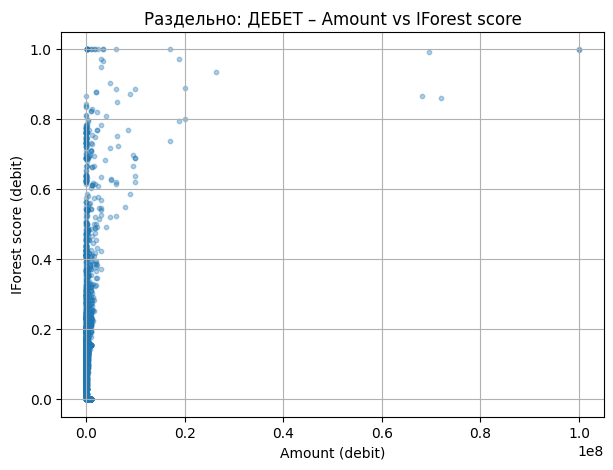

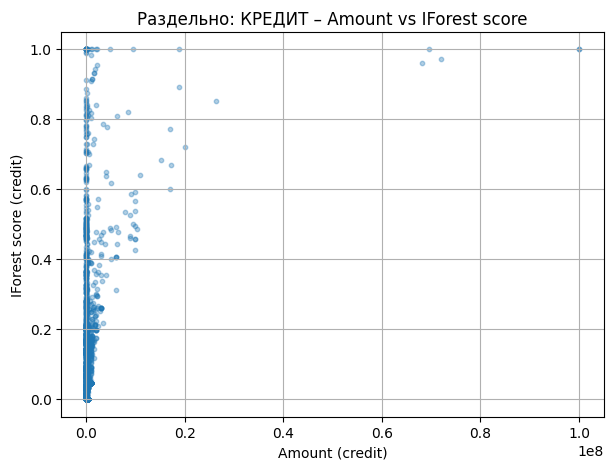

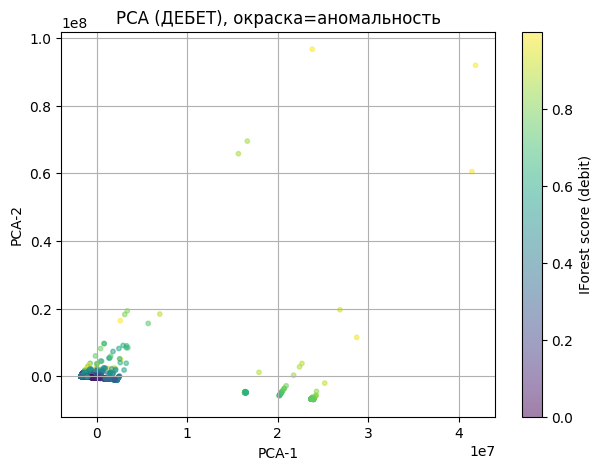

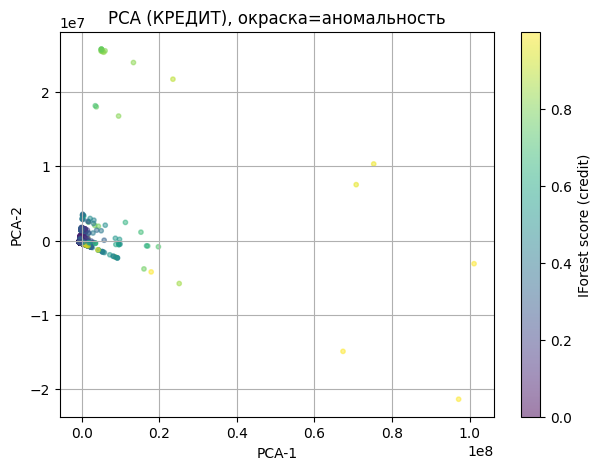

,txn_id,date,inn,side,amount,purpose,iforest_score_debit
1899,NaN,2021-07-06,8d9e0be733f77f1c,debit,100000000.0,выдача кредита по договору n600210017 от 24 ию...,1.000000
14,NaN,2019-01-15,ad57c94e5b8df8f6,debit,3400000.0,перевод денежных средств по договору займа № ч...,1.000000
493,NaN,2019-10-16,9d8f54ae3b88911b,debit,17000000.0,оплата по договору беспроцентного займа №ти-17...,1.000000
1799,NaN,2021-05-21,5ae9eeb0d29bc5c0,debit,2350000.0,перевод денежных средств по договору № пи-1/28...,1.000000
2242,NaN,2021-11-26,nan,debit,3500000.0,взнос займа по договору №34 от date_e98770c5fd...,1.000000
...,...,...,...,...,...,...,...
492,NaN,2019-10-16,d877722ca4e40f98,debit,17000000.0,оплата по счету № 20 от date_aa5e303a04cd аван...,0.738073
1953,NaN,2021-07-12,d877722ca4e40f98,debit,7705.0,оплата по счету № 6042 от 09.07.21г спецодежда...,0.736144
1952,NaN,2021-07-12,d877722ca4e40f98,debit,2790.0,оплата по договору электроэнергия по дог.№1124...,0.734545
1942,NaN,2021-07-09,d877722ca4e40f98,debit,80000.0,оплата по счету № 73 от date_63da1f80aee8 стро...,0.733509


,txn_id,date,inn,side,amount,purpose,iforest_score_credit
1898,NaN,2021-07-06,8d9e0be733f77f1c,credit,1.000000e+08,формирование покрытия по внутрироссийскому акк...,1.000000
1945,NaN,2021-07-09,6931e23e98703aa9,credit,6.950000e+07,окончательная оплата по счету №9 от date_aaac9...,1.000000
2508,NaN,2022-08-02,1b21a7645f64d170,credit,4.869204e+06,по решению о взыскании № 5593 от date_11c36260...,1.000000
1979,NaN,2021-07-20,80799e1a6646b6dc,credit,1.214381e+06,налог на имущество организаций за 1 квартал 20...,1.000000
1669,NaN,2021-03-31,480b91025f5be8d0,credit,4.000000e+05,частичный возврат займа по договору №2-ои/1509...,1.000000
...,...,...,...,...,...,...,...
1886,NaN,2021-06-30,d877722ca4e40f98,credit,1.729715e+07,"acc_cd27e0d43c60;ст. 176 нк рф, год: 2021 реше...",0.668435
2074,NaN,2021-09-03,8d9e0be733f77f1c,credit,4.909513e+04,заработная плата по реестру №22 от date_2ee8be...,0.666410
695,NaN,2020-03-27,ca3891c167141f4d,credit,1.287300e+02,взносы на обязательное страхование от несчастн...,0.664769
2520,NaN,2022-08-03,480b91025f5be8d0,credit,8.995100e+02,оплата по договору аренды кабинета по сч.№23 о...,0.661495


 Сохранено: top100_anomalous_txn_debit.csv
 Сохранено: top100_anomalous_txn_credit.csv


In [93]:
# === Ячейка 2. Раздельный анализ: отдельные модели для дебета и для кредита ===
# Для каждого ИНН считаем аномалии отдельно в дебетных и отдельно в кредитных операциях.
# Фильтр: в каждой роли ИНН должен иметь >=30 транзакций по этой роли.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10

# -------- 0) Подготовка отдельных таблиц --------
# ДЕБЕТ
deb_cols = [
    "id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
for c in deb_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","debit_inn"] else df.get(c, np.nan)

deb = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    # фичи роли
    "roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

# КРЕДИТ
cred_cols = [
    "id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]
for c in cred_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","credit_inn"] else df.get(c, np.nan)

cred = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

# -------- 1) Фильтры по количеству транзакций в каждой роли --------
deb_eligible = set(deb.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)
cred_eligible = set(cred.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >={MIN_TX_PER_INN} дебетных транзакций: {len(deb_eligible):,}")
print(f"ИНН с >={MIN_TX_PER_INN} кредитных транзакций: {len(cred_eligible):,}")
if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН с достаточным числом транзакций ни в дебете, ни в кредите.")

# -------- 2) IsolationForest по КАЖДОЙ роли и КАЖДОМУ ИНН --------

feat_cols = [
    "amount","roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d", "is_weekend", "is_month_end",

    
]

# оставляем первые 7 так как в PCA остальные колонки имеют 0 вес => создают шумы 
# feat_cols = [
#     # базовые суммы
#     "amount",
#     # поведенческие окна
#    "roll_cnt_30d","roll_mean_30d","roll_std_30d",
#     "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
#     # активность
#     "daily_debit_transaction_count", "daily_credit_transaction_count",
#     # доли в дневном объеме
#     "daily_debit_percent", "daily_credit_percent",
#     # интервалы между операциями
#     "days_since_last_txn_debit", "days_since_last_txn_credit",
#     # связи (fan-out / fan-in)
#     "debit_fan_out_ratio", "credit_fan_in_ratio",
#     # баланс вход/выход
#     "in_out_ratio_30d",
#     # округлённые суммы
#     "round_large_amount",
#     # время
#     "day_of_week", "is_weekend", "is_month_end"
# ]


for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit"] = np.nan
cred_w["iforest_score_credit"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

# Дебет
for inn in sorted(deb_eligible):
    sub = deb_w[deb_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    deb_w.loc[sub.index, "iforest_score_debit"] = s

# Кредит
for inn in sorted(cred_eligible):
    sub = cred_w[cred_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    cred_w.loc[sub.index, "iforest_score_credit"] = s


    

# -------- 3) Scatter-графики по ролям --------
# 3.1 Дебет: Amount vs iforest_score_debit
if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit)")
    plt.title("Раздельно: ДЕБЕТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# 3.2 Кредит: Amount vs iforest_score_credit
if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit)")
    plt.title("Раздельно: КРЕДИТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# (доп) PCA-проекции для каждой роли
if len(deb_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (ДЕБЕТ), окраска=аномальность")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (КРЕДИТ), окраска=аномальность")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций ПО ОТДЕЛЬНОСТИ --------
top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose","iforest_score_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose","iforest_score_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

# Сохранение
out_deb = "top100_anomalous_txn_debit.csv"
out_cred = "top100_anomalous_txn_credit.csv"
top100_debit[cols_out_deb].to_csv(out_deb, index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv(out_cred, index=False, encoding="utf-8-sig")
print(f" Сохранено: {out_deb}")
print(f" Сохранено: {out_cred}")


ИНН с >=10 дебетных транзакций: 10
ИНН с >=10 кредитных транзакций: 27


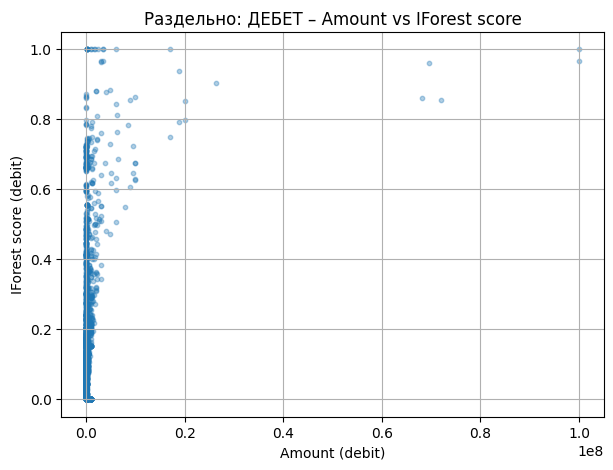

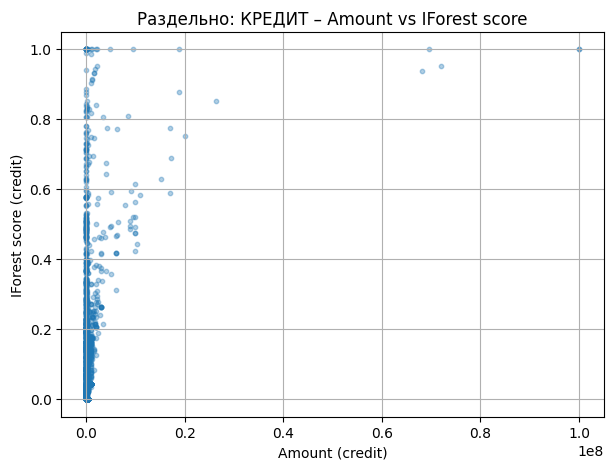

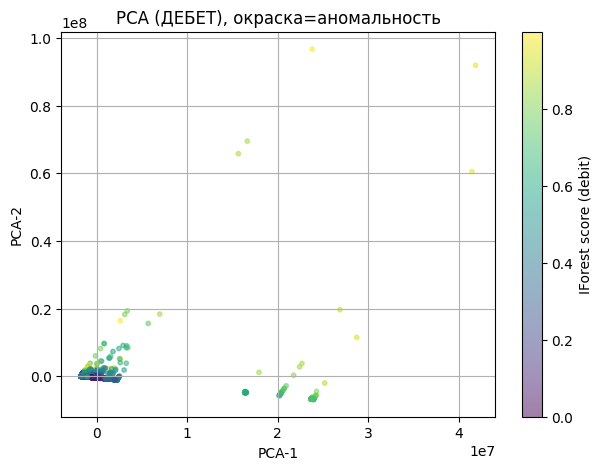

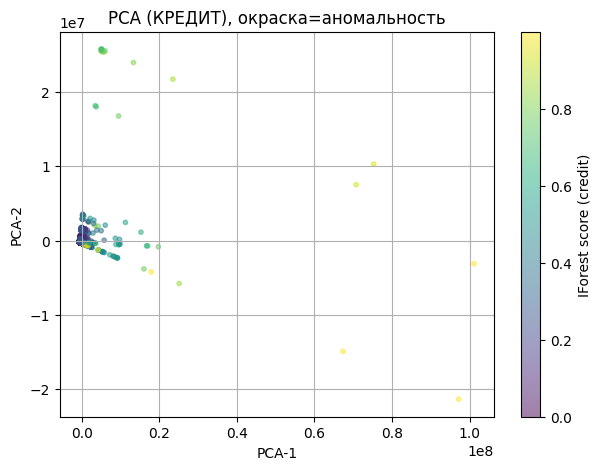

,txn_id,date,inn,side,amount,purpose,iforest_score_debit
1899,NaN,2021-07-06,8d9e0be733f77f1c,debit,1.000000e+08,выдача кредита по договору n600210017 от 24 ию...,1.000000
14,NaN,2019-01-15,ad57c94e5b8df8f6,debit,3.400000e+06,перевод денежных средств по договору займа № ч...,1.000000
493,NaN,2019-10-16,9d8f54ae3b88911b,debit,1.700000e+07,оплата по договору беспроцентного займа №ти-17...,1.000000
1799,NaN,2021-05-21,5ae9eeb0d29bc5c0,debit,2.350000e+06,перевод денежных средств по договору № пи-1/28...,1.000000
2242,NaN,2021-11-26,nan,debit,3.500000e+06,взнос займа по договору №34 от date_e98770c5fd...,1.000000
...,...,...,...,...,...,...,...
1973,NaN,2021-07-20,d877722ca4e40f98,debit,4.683785e+04,налог на имущество организаций за 1 квартал 20...,0.705217
1972,NaN,2021-07-20,d877722ca4e40f98,debit,3.749998e+04,аванс по заработной плате по реестру №16 от da...,0.703968
1971,NaN,2021-07-20,d877722ca4e40f98,debit,1.941300e+04,земельный налог за 2 квартал 2021 года,0.700999
1960,NaN,2021-07-13,d877722ca4e40f98,debit,8.000000e+00,комиссия внутри сбербанка за пп/пт через дбо с...,0.700417


,txn_id,date,inn,side,amount,purpose,iforest_score_credit
1898,NaN,2021-07-06,8d9e0be733f77f1c,credit,1.000000e+08,формирование покрытия по внутрироссийскому акк...,1.000000
1945,NaN,2021-07-09,6931e23e98703aa9,credit,6.950000e+07,окончательная оплата по счету №9 от date_aaac9...,1.000000
2508,NaN,2022-08-02,1b21a7645f64d170,credit,4.869204e+06,по решению о взыскании № 5593 от date_11c36260...,1.000000
1979,NaN,2021-07-20,80799e1a6646b6dc,credit,1.214381e+06,налог на имущество организаций за 1 квартал 20...,1.000000
1669,NaN,2021-03-31,480b91025f5be8d0,credit,4.000000e+05,частичный возврат займа по договору №2-ои/1509...,1.000000
...,...,...,...,...,...,...,...
1635,NaN,2021-03-12,1d83fd5f5fefc19f,credit,5.474240e+05,оплата по договору № 3510 от date_f300508e7393...,0.678766
2661,NaN,2023-12-08,d877722ca4e40f98,credit,4.041209e+06,оплата по сч. 70 от date_205f0adc40bf. сумма 4...,0.674275
2093,NaN,2021-09-20,6290b8d67943ece5,credit,1.363360e+03,заработная плата за первую половину сентября 2...,0.672767
1073,NaN,2020-09-16,0c22384d93788af3,credit,3.945360e+05,арендная плата за землю по договору №13866 от ...,0.672099


 Сохранено: top100_anomalous_txn_debit_tfidf.csv
 Сохранено: top100_anomalous_txn_credit_tfidf.csv


In [97]:
# === Ячейка 2. Раздельный анализ: отдельные модели для дебета и для кредита ===
# Для каждого ИНН считаем аномалии отдельно в дебетных и отдельно в кредитных операциях.
# Фильтр: в каждой роли ИНН должен иметь >=30 транзакций по этой роли.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10

# -------- 0) Подготовка отдельных таблиц --------
# ДЕБЕТ
deb_cols = [
    "id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
for c in deb_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","debit_inn"] else df.get(c, np.nan)

deb = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    # фичи роли
    "roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

# КРЕДИТ
cred_cols = [
    "id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]
for c in cred_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","credit_inn"] else df.get(c, np.nan)

cred = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

# -------- 1) Фильтры по количеству транзакций в каждой роли --------
deb_eligible = set(deb.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)
cred_eligible = set(cred.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >={MIN_TX_PER_INN} дебетных транзакций: {len(deb_eligible):,}")
print(f"ИНН с >={MIN_TX_PER_INN} кредитных транзакций: {len(cred_eligible):,}")
if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН с достаточным числом транзакций ни в дебете, ни в кредите.")

# -------- 2) IsolationForest по КАЖДОЙ роли и КАЖДОМУ ИНН --------

feat_cols = [
    "amount","roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d", "is_weekend", "is_month_end",

    "purpose_stopword_high",
    
    
]
# оставляем первые 7 так как в PCA остальные колонки имеют 0 вес => создают шумы 
# feat_cols = [
#     # базовые суммы
#     "amount",
#     # поведенческие окна
#    "roll_cnt_30d","roll_mean_30d","roll_std_30d",
#     "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
#     # активность
#     "daily_debit_transaction_count", "daily_credit_transaction_count",
#     # доли в дневном объеме
#     "daily_debit_percent", "daily_credit_percent",
#     # интервалы между операциями
#     "days_since_last_txn_debit", "days_since_last_txn_credit",
#     # связи (fan-out / fan-in)
#     "debit_fan_out_ratio", "credit_fan_in_ratio",
#     # баланс вход/выход
#     "in_out_ratio_30d",
#     # округлённые суммы
#     "round_large_amount",
#     # время
#     "day_of_week", "is_weekend", "is_month_end"
# ]


for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit"] = np.nan
cred_w["iforest_score_credit"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

# Дебет
for inn in sorted(deb_eligible):
    sub = deb_w[deb_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    deb_w.loc[sub.index, "iforest_score_debit"] = s

# Кредит
for inn in sorted(cred_eligible):
    sub = cred_w[cred_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    cred_w.loc[sub.index, "iforest_score_credit"] = s


    

# -------- 3) Scatter-графики по ролям --------
# 3.1 Дебет: Amount vs iforest_score_debit
if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit)")
    plt.title("Раздельно: ДЕБЕТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# 3.2 Кредит: Amount vs iforest_score_credit
if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit)")
    plt.title("Раздельно: КРЕДИТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# (доп) PCA-проекции для каждой роли
if len(deb_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (ДЕБЕТ), окраска=аномальность")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (КРЕДИТ), окраска=аномальность")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций ПО ОТДЕЛЬНОСТИ --------
top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose","iforest_score_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose","iforest_score_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

# Сохранение
out_deb = "top100_anomalous_txn_debit_tfidf.csv"
out_cred = "top100_anomalous_txn_credit_tfidf.csv"
top100_debit[cols_out_deb].to_csv(out_deb, index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv(out_cred, index=False, encoding="utf-8-sig")
print(f" Сохранено: {out_deb}")
print(f" Сохранено: {out_cred}")

In [84]:
pca.components_

array([[ 9.77345650e-01,  1.19825004e-07,  6.37838530e-02,
         2.01809565e-01,  3.86056293e-08,  1.52375282e-08,
         4.70915392e-08, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-2.11453655e-01,  6.35667224e-07,  3.35268118e-01,
         9.18086402e-01,  8.27454722e-08,  7.58634128e-08,
         1.79766681e-07, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00]])

In [85]:
def permutation_importance_iso(model, X, n_repeats=5):
    base_scores = model.decision_function(X)
    importances = []

    for col in X.columns:
        diffs = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            X_perm[col] = np.random.permutation(X_perm[col].values)
            perm_scores = model.decision_function(X_perm)
            # чем сильнее изменилась оценка аномалии, тем важнее фича
            diffs.append(1 - np.corrcoef(base_scores, perm_scores)[0, 1])
        importances.append(np.mean(diffs))
    return pd.Series(importances, index=X.columns).sort_values(ascending=False)
importance_iso = permutation_importance_iso(iso, pd.DataFrame(X, columns=feat_cols))
print(importance_iso)

amount                  NaN
roll_cnt_30d            NaN
roll_mean_30d           NaN
roll_std_30d            NaN
amount_spike_ratio_7d   NaN
tx_rate_spike_7d        NaN
amount_volatility_30d   NaN
is_weekend              NaN
is_month_end            NaN
purpose_stopword_high   NaN
dtype: float64


In [86]:
df['is_month_end'].value_counts()

is_month_end
0    2583
1     105
Name: count, dtype: int64

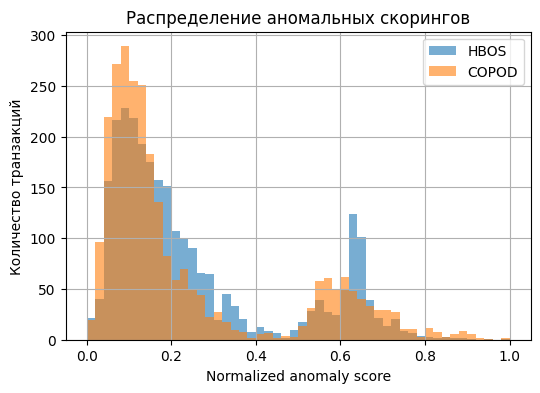

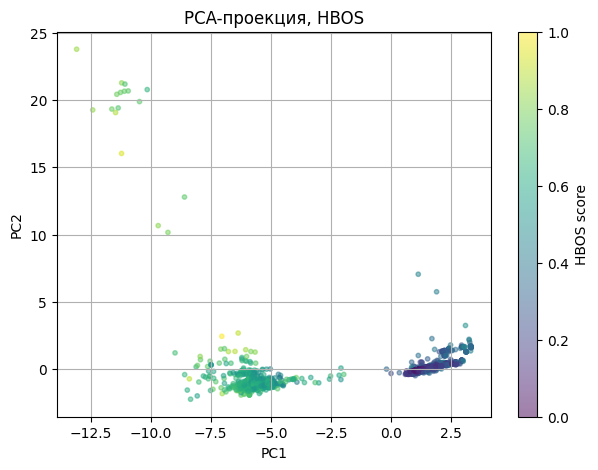

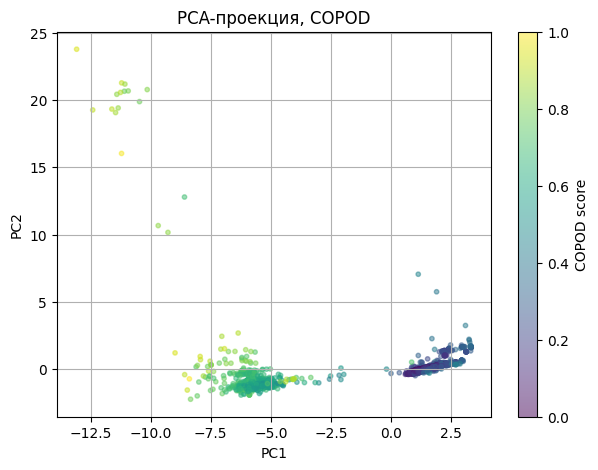

 Сохранено: top100_hbos.csv, top100_copod.csv
Топ-10 наиболее информативных признаков по PCA:
                                PCA_importance
credit_roll_std_30d                   0.678037
in_out_ratio_30d                      0.674406
credit_roll_mean_30d                  0.673053
credit_fan_in_ratio                   0.384473
debit_fan_out_ratio                   0.368734
daily_credit_transaction_count        0.348348
credit_roll_cnt_30d                   0.344348
credit_tx_rate_spike_7d               0.342821
credit_amount_volatility_30d          0.325195
debit_roll_cnt_30d                    0.313421


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# если PyOD не установлен: pip install pyod
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD


feat_cols = [
    # базовая сумма
    "amount",

    # поведенческие окна: дебет
    "debit_roll_cnt_30d", "debit_roll_mean_30d", "debit_roll_std_30d",
    "debit_amount_spike_ratio_7d", "debit_tx_rate_spike_7d", "debit_amount_volatility_30d",

    # поведенческие окна: кредит
    "credit_roll_cnt_30d", "credit_roll_mean_30d", "credit_roll_std_30d",
    "credit_amount_spike_ratio_7d", "credit_tx_rate_spike_7d", "credit_amount_volatility_30d",

    # активность за день
    "daily_debit_transaction_count", "daily_credit_transaction_count",

    # доля текущей операции в суточном объёме
    "daily_debit_percent", "daily_credit_percent",

    # интервалы между операциями (в днях)
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # fan-out / fan-in
    "debit_fan_out_ratio", "credit_fan_in_ratio",

    # дисбаланс потоков
    "in_out_ratio_30d",

    # округлённые суммы
    "round_large_amount",

    # время
    "day_of_week", "is_weekend", "is_month_end",

    
    
    
] 

RANDOM_STATE = 42

# --- 1) Подготовка данных ---
X = df[feat_cols].replace([np.inf, -np.inf], 0).fillna(0.0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- 2) HBOS ---
hbos = HBOS(contamination=0.02)     # 2 % аномалий по умолчанию
hbos.fit(Xs)
score_hbos = hbos.decision_function(Xs)   # чем выше — аномальнее
score_hbos = (score_hbos - score_hbos.min()) / (score_hbos.max() - score_hbos.min() + 1e-9)
df["hbos_score"] = score_hbos

# --- 3) COPOD ---
copod = COPOD(contamination=0.02)
copod.fit(Xs)
score_copod = copod.decision_function(Xs)
score_copod = (score_copod - score_copod.min()) / (score_copod.max() - score_copod.min() + 1e-9)
df["copod_score"] = score_copod

# --- 4) Визуализация распределений ---
plt.figure(figsize=(6,4))
plt.hist(df["hbos_score"], bins=50, alpha=0.6, label="HBOS")
plt.hist(df["copod_score"], bins=50, alpha=0.6, label="COPOD")
plt.legend(); plt.title("Распределение аномальных скорингов")
plt.xlabel("Normalized anomaly score"); plt.ylabel("Количество транзакций")
plt.grid(True); plt.show()

# --- 5) PCA для 2D-проекции ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["hbos_score"], s=10, alpha=0.5)
plt.colorbar(label="HBOS score"); plt.title("PCA-проекция, HBOS")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["copod_score"], s=10, alpha=0.5)
plt.colorbar(label="COPOD score"); plt.title("PCA-проекция, COPOD")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

# --- 6) Топ-100 подозрительных транзакций ---
top100_hbos = df.sort_values("hbos_score", ascending=False).head(2000)
top100_copod = df.sort_values("copod_score", ascending=False).head(2000)

cols_out = ["date","debit_inn","credit_inn","amount","purpose","hbos_score","copod_score"]
top100_hbos[cols_out].to_csv("top100_hbos.csv", index=False, encoding="utf-8-sig")
top100_copod[cols_out].to_csv("top100_copod.csv", index=False, encoding="utf-8-sig")

print(" Сохранено: top100_hbos.csv, top100_copod.csv")

# --- 7) Полезность признаков (через PCA-нагрузки) ---
loadings = pd.DataFrame(
    np.abs(pca.components_).sum(axis=0),
    index=feat_cols,
    columns=["PCA_importance"]
).sort_values("PCA_importance", ascending=False)
print("Топ-10 наиболее информативных признаков по PCA:")
print(loadings.head(10))


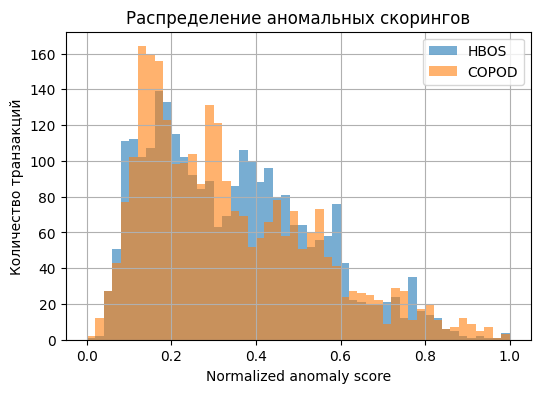

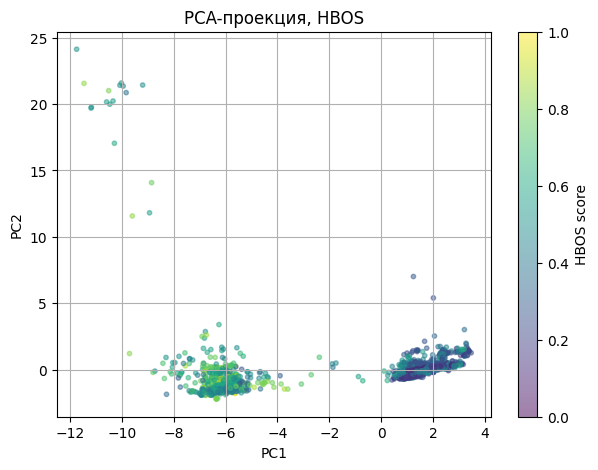

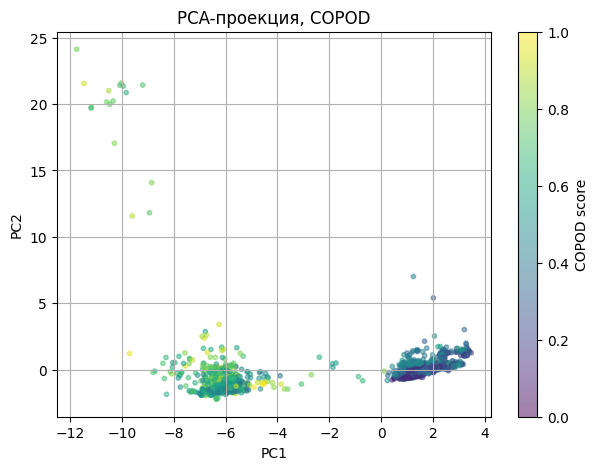

 Сохранено: top100_hbos_tfidf.csv, top100_copod_tfidf.csv
Топ-10 наиболее информативных признаков по PCA:
                                PCA_importance
credit_roll_std_30d                   0.646799
in_out_ratio_30d                      0.640984
credit_roll_mean_30d                  0.639870
credit_fan_in_ratio                   0.346314
daily_credit_transaction_count        0.331952
debit_fan_out_ratio                   0.330255
credit_roll_cnt_30d                   0.310874
credit_tx_rate_spike_7d               0.305851
credit_amount_volatility_30d          0.286589
debit_amount_volatility_30d           0.282102


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# если PyOD не установлен: pip install pyod
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD


feat_cols = [
    # базовая сумма
    "amount",

    # поведенческие окна: дебет
    "debit_roll_cnt_30d", "debit_roll_mean_30d", "debit_roll_std_30d",
    "debit_amount_spike_ratio_7d", "debit_tx_rate_spike_7d", "debit_amount_volatility_30d",

    # поведенческие окна: кредит
    "credit_roll_cnt_30d", "credit_roll_mean_30d", "credit_roll_std_30d",
    "credit_amount_spike_ratio_7d", "credit_tx_rate_spike_7d", "credit_amount_volatility_30d",

    # активность за день
    "daily_debit_transaction_count", "daily_credit_transaction_count",

    # доля текущей операции в суточном объёме
    "daily_debit_percent", "daily_credit_percent",

    # интервалы между операциями (в днях)
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # fan-out / fan-in
    "debit_fan_out_ratio", "credit_fan_in_ratio",

    # дисбаланс потоков
    "in_out_ratio_30d",

    # округлённые суммы
    "round_large_amount",

    # время
    "day_of_week", "is_weekend", "is_month_end",

    "purpose_stopword_high",
    
    
] + [f"purpose_svd_{i}" for i in range(1,51)]

RANDOM_STATE = 42

# --- 1) Подготовка данных ---
X = df[feat_cols].replace([np.inf, -np.inf], 0).fillna(0.0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- 2) HBOS ---
hbos = HBOS(contamination=0.02)     # 2 % аномалий по умолчанию
hbos.fit(Xs)
score_hbos = hbos.decision_function(Xs)   # чем выше — аномальнее
score_hbos = (score_hbos - score_hbos.min()) / (score_hbos.max() - score_hbos.min() + 1e-9)
df["hbos_score"] = score_hbos

# --- 3) COPOD ---
copod = COPOD(contamination=0.02)
copod.fit(Xs)
score_copod = copod.decision_function(Xs)
score_copod = (score_copod - score_copod.min()) / (score_copod.max() - score_copod.min() + 1e-9)
df["copod_score"] = score_copod

# --- 4) Визуализация распределений ---
plt.figure(figsize=(6,4))
plt.hist(df["hbos_score"], bins=50, alpha=0.6, label="HBOS")
plt.hist(df["copod_score"], bins=50, alpha=0.6, label="COPOD")
plt.legend(); plt.title("Распределение аномальных скорингов")
plt.xlabel("Normalized anomaly score"); plt.ylabel("Количество транзакций")
plt.grid(True); plt.show()

# --- 5) PCA для 2D-проекции ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["hbos_score"], s=10, alpha=0.5)
plt.colorbar(label="HBOS score"); plt.title("PCA-проекция, HBOS")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["copod_score"], s=10, alpha=0.5)
plt.colorbar(label="COPOD score"); plt.title("PCA-проекция, COPOD")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

# --- 6) Топ-100 подозрительных транзакций ---
top100_hbos = df.sort_values("hbos_score", ascending=False).head(2000)
top100_copod = df.sort_values("copod_score", ascending=False).head(2000)

cols_out = ["date","debit_inn","credit_inn","amount","purpose","hbos_score","copod_score"]
top100_hbos[cols_out].to_csv("top100_hbos_tfidf.csv", index=False, encoding="utf-8-sig")
top100_copod[cols_out].to_csv("top100_copod_tfidf.csv", index=False, encoding="utf-8-sig")

print(" Сохранено: top100_hbos_tfidf.csv, top100_copod_tfidf.csv")

# --- 7) Полезность признаков (через PCA-нагрузки) ---
loadings = pd.DataFrame(
    np.abs(pca.components_).sum(axis=0),
    index=feat_cols,
    columns=["PCA_importance"]
).sort_values("PCA_importance", ascending=False)
print("Топ-10 наиболее информативных признаков по PCA:")
print(loadings.head(10))


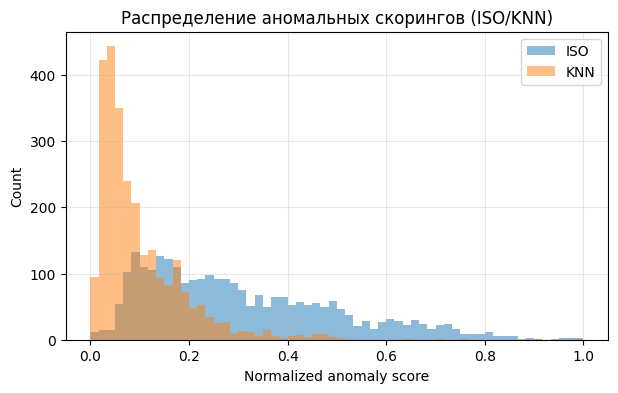

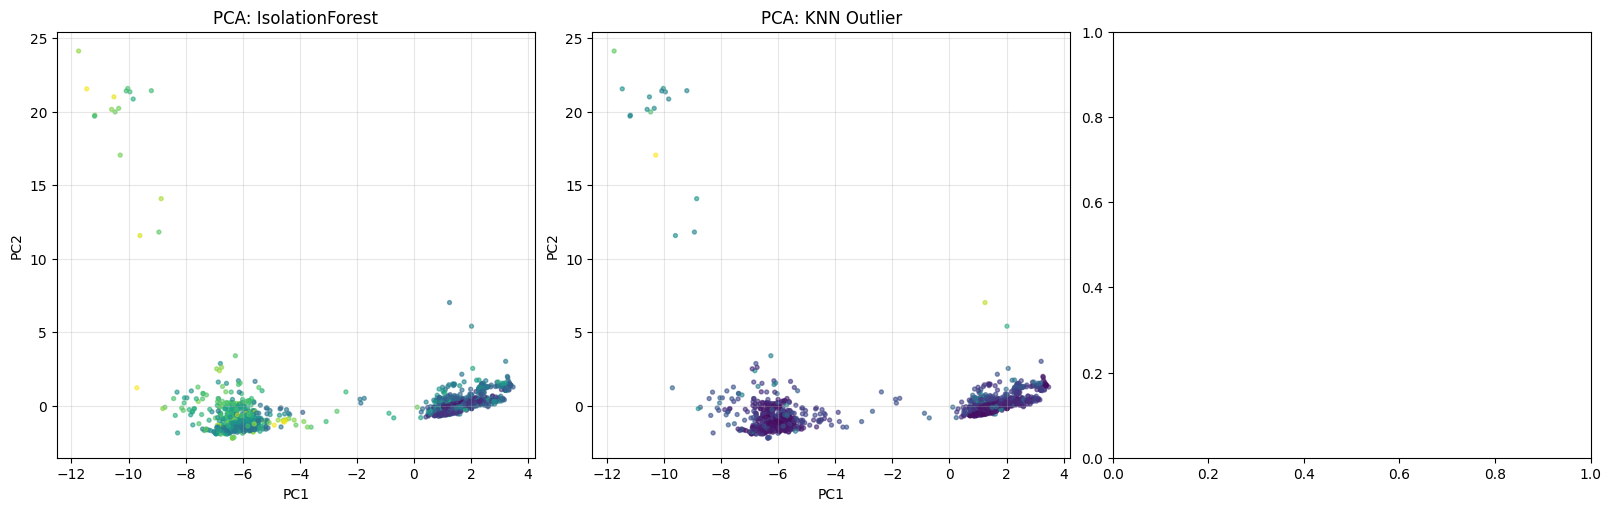

 Сохранено: top100_iso.csv, top100_knn.csv
Топ-12 информативных признаков по PCA:
                                PCA_importance
credit_roll_std_30d                   0.646799
in_out_ratio_30d                      0.640984
credit_roll_mean_30d                  0.639870
credit_fan_in_ratio                   0.346314
daily_credit_transaction_count        0.331952
debit_fan_out_ratio                   0.330255
credit_roll_cnt_30d                   0.310874
credit_tx_rate_spike_7d               0.305851
credit_amount_volatility_30d          0.286589
debit_amount_volatility_30d           0.282102
debit_roll_cnt_30d                    0.279927
amount                                0.276897
Совпадений ISO ∩ KNN: 0


In [92]:
# !pip install pyod tensorflow  # если нет: pyod (обязательно), tensorflow (для AutoEncoder)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder  # требует keras/tensorflow

RANDOM_STATE = 42

# --- 0) Фичи (как у тебя в документе) ---
feat_cols = [
    # базовая сумма
    "amount",

    # поведенческие окна: дебет
    "debit_roll_cnt_30d", "debit_roll_mean_30d", "debit_roll_std_30d",
    "debit_amount_spike_ratio_7d", "debit_tx_rate_spike_7d", "debit_amount_volatility_30d",

    # поведенческие окна: кредит
    "credit_roll_cnt_30d", "credit_roll_mean_30d", "credit_roll_std_30d",
    "credit_amount_spike_ratio_7d", "credit_tx_rate_spike_7d", "credit_amount_volatility_30d",

    # активность за день
    "daily_debit_transaction_count", "daily_credit_transaction_count",

    # доля текущей операции в суточном объёме
    "daily_debit_percent", "daily_credit_percent",

    # интервалы между операциями (в днях)
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # fan-out / fan-in
    "debit_fan_out_ratio", "credit_fan_in_ratio",

    # дисбаланс потоков
    "in_out_ratio_30d",

    # округлённые суммы
    "round_large_amount",

    # время
    "day_of_week", "is_weekend", "is_month_end",
    
    "purpose_stopword_high",
    
] + [f"purpose_svd_{i}" for i in range(1,51)]

# --- 1) Подготовка данных ---
X = df[feat_cols].replace([np.inf, -np.inf], 0.0).fillna(0.0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

def minmax01(arr):
    arr = np.asarray(arr)
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    denom = (mx - mn) if (mx - mn) != 0 else 1.0
    return (arr - mn) / (denom + 1e-9)

# --- 2) PCA для визуализаций (один раз) ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(Xs)

# === A) IsolationForest ===
iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso.fit(Xs)
iso_raw = -iso.score_samples(Xs)           # больше = аномальнее
df["iso_score"] = minmax01(iso_raw)

# === B) KNN Outlier Detection (PyOD) ===
# метод "largest" или "mean" — классические варианты; metric='minkowski' по умолчанию.
knn = KNN(contamination=0.02, n_neighbors=10, method='largest')
knn.fit(Xs)
# В PyOD: decision_scores_ — чем БОЛЬШЕ, тем аномальнее (как нам и нужно)
df["knn_score"] = minmax01(knn.decision_scores_)

# === C) AutoEncoder (PyOD) ===
# Если нет TensorFlow, закомментируй этот блок
# общие kwargs (одинаковы для старых и новых версий PyOD)


# --- 3) Визуализация распределений (гистограммы) ---
plt.figure(figsize=(7,4))
plt.hist(df["iso_score"], bins=60, alpha=0.5, label="ISO")
plt.hist(df["knn_score"], bins=60, alpha=0.5, label="KNN")
plt.legend()
plt.title("Распределение аномальных скорингов (ISO/KNN)")
plt.xlabel("Normalized anomaly score")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# --- 4) PCA-проекции, окраска скором каждого алгоритма ---
def scatter_pca(ax, Xp, color, title):
    sc = ax.scatter(Xp[:,0], Xp[:,1], c=color, s=8, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)
    return sc

fig, axes = plt.subplots(1, 3, figsize=(16,5), constrained_layout=True)
sc1 = scatter_pca(axes[0], Xp, df["iso_score"], "PCA: IsolationForest")
sc2 = scatter_pca(axes[1], Xp, df["knn_score"], "PCA: KNN Outlier")




plt.show()

# --- 5) Сохранение топ-100 самых подозрительных транзакций по каждому алгоритму ---
cols_out = ["date","debit_inn","credit_inn","amount","purpose"]
top100_iso  = df.sort_values("iso_score", ascending=False).head(100)[cols_out + ["iso_score"]]
top100_knn  = df.sort_values("knn_score", ascending=False).head(100)[cols_out + ["knn_score"]]


top100_iso.to_csv("top100_iso.csv", index=False, encoding="utf-8-sig")
top100_knn.to_csv("top100_knn.csv", index=False, encoding="utf-8-sig")

print(" Сохранено: top100_iso.csv, top100_knn.csv")

# --- 6) Быстрая «полезность фич» (через PCA-нагрузки — структурная вариация) ---
loadings = pd.DataFrame(
    np.abs(pca.components_).sum(axis=0),
    index=feat_cols, columns=["PCA_importance"]
).sort_values("PCA_importance", ascending=False)
print("Топ-12 информативных признаков по PCA:")
print(loadings.head(12))

# --- 7) Пересечения топов (на глаз, насколько алгоритмы согласны) ---
set_iso = set(df.sort_values("iso_score", ascending=False).head(100)["id"])
set_knn = set(df.sort_values("knn_score", ascending=False).head(100)["id"])


print(f"Совпадений ISO ∩ KNN: {len(set_iso & set_knn)}")



In [107]:

!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/200.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/200.1 MB 2.3 MB/s eta 0:01:27
     ---------------------------------------- 0.2/200.1 MB 2.0 MB/s eta 0:01:42
     ---------------------------------------- 0.2/200.1 MB 2.0 MB/s eta 0:01:43
     ---------------------------------------- 0.3/200.1 MB 1.7 MB/s eta 0:02:00
     ---------------------------------------- 0.4/200.1 MB 1.7 MB/s eta 0:01:59
     ---------------------------------------- 0.5/200.1 MB 1.7 MB/s eta 0:01:56
     ---------------------------------------- 0.6/200.1 MB 1.8 MB/s eta 0:01:53
     ---------------------------------------- 0.8/200.1 MB 2.1 MB/s eta 0:01:34
     ---------------------------------------- 1.0/200.1 MB 2.3 MB/s eta 0:01:26
     ---------------------------------------- 1.0/200.1 MB 2.3 MB/s eta 0:01:27
     ---------------------------------------- 1.3/200.1 MB 2.5 MB/s et


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [116]:
!pip install torch==2.2.1
!pip install torchdata==0.7.1
!pip install dgl 

   ---------------------------------------- 0.0/198.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/198.5 MB 330.3 kB/s eta 0:10:01
   ---------------------------------------- 0.0/198.5 MB 660.6 kB/s eta 0:05:01
   ---------------------------------------- 0.0/198.5 MB 393.8 kB/s eta 0:08:24
   ---------------------------------------- 0.1/198.5 MB 328.2 kB/s eta 0:10:05
   ---------------------------------------- 0.1/198.5 MB 383.3 kB/s eta 0:08:38
   ---------------------------------------- 0.1/198.5 MB 409.6 kB/s eta 0:08:05
   ---------------------------------------- 0.2/198.5 MB 517.2 kB/s eta 0:06:24
   ---------------------------------------- 0.2/198.5 MB 562.0 kB/s eta 0:05:53
   ---------------------------------------- 0.2/198.5 MB 541.9 kB/s eta 0:06:06
   ---------------------------------------- 0.3/198.5 MB 562.4 kB/s eta 0:05:53
   ---------------------------------------- 0.4/198.5 MB 740.5 kB/s eta 0:04:28
   ---------------------------------------- 0.5/1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cpu requires torch==2.4.0, but you have torch 2.2.1 which is incompatible.
torchvision 0.19.0+cpu requires torch==2.4.0, but you have torch 2.2.1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


^C



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached dgl-2.2.1-cp312-cp312-win_amd64.whl.metadata (595 bytes)
Using cached dgl-2.2.1-cp312-cp312-win_amd64.whl (5.3 MB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
!pip install dgl 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [139]:
# pip install pandas numpy scikit-learn networkx gensim
import numpy as np
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from datetime import timedelta

def build_graph_and_node2vec(df, node_col_src="debit_inn", node_col_dst="credit_inn",
                             walk_len=40, walks_per_node=10, emb_dim=64, seed=42):
    # nodes as strings
    df = df.copy()
    df['src'] = df[node_col_src].astype(str)
    df['dst'] = df[node_col_dst].astype(str)
    G = nx.DiGraph()
    G.add_edges_from(zip(df['src'], df['dst']))
    nodes = list(G.nodes())
    # random walks (simple)
    import random
    random.seed(seed)
    walks = []
    for node in nodes:
        for _ in range(walks_per_node):
            walk = [node]
            while len(walk) < walk_len:
                cur = walk[-1]
                nbrs = list(G.successors(cur))
                if not nbrs:
                    break
                walk.append(random.choice(nbrs))
            walks.append(walk)
    # Word2Vec on walks
    w2v = Word2Vec(walks, vector_size=emb_dim, window=5, min_count=1, sg=1, workers=4, seed=seed, epochs=5)
    # mapping -> embedding
    emb = {node: w2v.wv[node] for node in nodes}
    return emb

def edge_features_with_rule_signals(df, emb, emb_dim=64,
                                    date_col="date", src_col="debit_inn", dst_col="credit_inn"):
    """
    Builds edge-level features and the rule signals:
      - same_day_tx_count (for sender)
      - unique_counterparties_3d (for sender in rolling 3-day window)
      - chain_count (how many chains of length>=3 this tx participates in within same day)
    """
    df = df.copy()
    # ensure datetime
    df[date_col] = pd.to_datetime(df[date_col])
    # add simple features used later
    df['src'] = df[src_col].astype(str)
    df['dst'] = df[dst_col].astype(str)
    n = len(df)
    # 1) same_day_tx_count per sender (count of txs for same src on same date)
    df['date_only'] = df[date_col].dt.floor('D')
    df['same_day_tx_count'] = df.groupby(['src','date_only'])['src'].transform('count')
    # 2) unique counterparties in 3-day window for sender
    # we'll compute for each row: unique dsts for src in [date-2, date]
    df = df.sort_values(date_col).reset_index(drop=True)
    unique_3d = []
    # build groupby lists for quick slicing
    grouped = df.groupby('src')
    for src, group in grouped:
        # group sorted by date
        # for each idx in group, compute unique dsts in window [d-2d, d]
        dsts = group['dst'].values
        dates = group['date_only'].values
        # convert to list for sliding window
        idxs = group.index.tolist()
        # sliding window pointers
        from collections import deque, defaultdict
        window = deque()
        counter = defaultdict(int)
        left = 0
        for i, idx in enumerate(idxs):
            dcur = dates[i]
            # remove older than dcur - 2 days
            while left < i and (dcur - dates[left]).astype('timedelta64[D]').astype(int) > 2:
                old_dst = dsts[left]
                counter[old_dst] -= 1
                if counter[old_dst] == 0:
                    del counter[old_dst]
                left += 1
            # add current
            counter[dsts[i]] += 1
            unique_3d.append(len(counter))
    # unique_3d list is in order of grouped iteration; need to assign back - simpler to recompute per row using rolling with sets
    # fallback: compute per-row by querying group window (vectorized-ish)
    df['unique_counterparties_3d'] = 0
    # Use windowed approach per src to be safe
    for src, group in df.groupby('src'):
        idxs = group.index
        dates = group['date_only']
        dsts = group['dst']
        for i, idx in enumerate(idxs):
            dcur = dates.loc[idx]
            mask = (dates >= dcur - pd.Timedelta(days=2)) & (dates <= dcur)
            df.at[idx, 'unique_counterparties_3d'] = dsts[mask].nunique()
    # 3) chain participation count (within same day): find sequences of directed transfers u->v->w->x
    # Build per-day directed adjacency lists and find all paths length>=3; mark edges that lie in any such path
    df['chain_participation'] = 0
    # for speed, index transactions by day
    for day, day_df in df.groupby('date_only'):
        # build mapping from (src,dst) to list of transaction indices happening on that day in chronological order
        # but we only need graph topology per day
        Gd = nx.DiGraph()
        # we will keep edge->list of tx indices
        edge_to_idxs = {}
        for idx, row in day_df.iterrows():
            u = row['src']; v = row['dst']
            Gd.add_edge(u, v)
            edge_to_idxs.setdefault((u,v), []).append(idx)
        # find all simple paths of length 3 (edges 0->1->2->3 means path length nodes 4? we want >=3 transactions in chain => path of length >=3 edges)
        # Here require chain with at least 3 transactions (edges), i.e., path length edges >=3 
        # We'll find all paths up to length 6 to avoid explosion; but typically degree small.
        for u in list(Gd.nodes()):
            # depth-limited DFS
            stack = [(u, [u])]
            while stack:
                node, path = stack.pop()
                if len(path)-1 >= 3:
                    # mark every edge in this path as participating
                    edges_in_path = list(zip(path[:-1], path[1:]))
                    for e in edges_in_path:
                        for tx_idx in edge_to_idxs.get(e, []):
                            df.at[tx_idx, 'chain_participation'] += 1
                if len(path)-1 >= 6:
                    continue
                for nbr in Gd.successors(node):
                    if nbr in path:
                        continue
                    stack.append((nbr, path + [nbr]))
    # 4) node2vec embeddings into edge features: concat src_emb + dst_emb
    emb_dim_act = emb_dim
    src_embs = np.vstack([emb.get(s, np.zeros(emb_dim_act, dtype=float)) for s in df['src']])
    dst_embs = np.vstack([emb.get(d, np.zeros(emb_dim_act, dtype=float)) for d in df['dst']])
    # 5) other numeric features (normalize later)
    numeric_cols = [
        'amount','same_day_tx_count','unique_counterparties_3d','chain_participation',
        'daily_debit_percent','daily_credit_percent',
        'days_since_last_txn_debit','days_since_last_txn_credit',
        'in_out_ratio_30d'
    ]
    exist = [c for c in numeric_cols if c in df.columns]
    X_tab = df[exist].replace([np.inf,-np.inf],0).fillna(0.0).values
    # assemble final edge matrix: [src_emb | dst_emb | tabular]
    X_edge = np.hstack([src_embs, dst_embs, X_tab])
    return df, X_edge, exist

def compute_scores(df, X_edge, exist_cols, random_state=42):
    # scale and fit IsolationForest
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_edge)
    iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=random_state, n_jobs=-1)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)  # more = more anomalous
    raw_norm = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    df['iso_score'] = raw_norm
    # rule based soft scores (0..1)
    # scale each rule-driven signal to [0,1] and combine
    # same_day_tx_count >=3 -> strong indicator
    s1 = np.clip((df['same_day_tx_count'] - 1) / (10.0), 0, 1)   # low->0, >=11->1 ; tuned soft
    s1 = np.where(df['same_day_tx_count'] >= 3, 1.0, s1*0.0 + 0.0)  # make binary for clarity if prefer: assign 1 when >=3
    # unique counterparties 3d -> threshold 10
    s2 = np.clip(df['unique_counterparties_3d'] / 10.0, 0, 1)
    # chain participation -> if participates in any long chain -> 1
    s3 = np.clip(df['chain_participation'] / 5.0, 0, 1)
    # rule_score combine (max or weighted)
    rule_score = np.maximum.reduce([s1, s2, s3])  # OR logic: any signal => strong
    df['rule_score'] = rule_score
    # final risk: weighted ensemble: give rule signals higher weight (so regulatory rules matter)
    alpha = 0.6  # weight for rule_score
    beta = 0.4   # weight for iso_score
    df['risk_score'] = (alpha * df['rule_score'] + beta * df['iso_score'])
    # normalize final to [0,1]
    df['risk_score'] = (df['risk_score'] - df['risk_score'].min()) / (df['risk_score'].max() - df['risk_score'].min() + 1e-9)
    return df

# ---------- USAGE ----------
# assume df already loaded and has core columns: id, date, debit_inn, credit_inn, amount, etc.

# 1) compute node2vec embeddings
emb = build_graph_and_node2vec(df, walk_len=30, walks_per_node=8, emb_dim=32)

# 2) build features and rule signals, and get edge matrix
df2, X_edge, exist_cols = edge_features_with_rule_signals(df, emb, emb_dim=32)

# 3) ML scoring + combine with rule signals
df_scored = compute_scores(df2, X_edge, exist_cols)

# 4) output top suspected transactions
top100 = df_scored.sort_values("risk_score", ascending=False).head(1000)
top100[['id','date','debit_inn','credit_inn','amount','risk_score','rule_score','iso_score']].to_csv("top100_mldetect.csv", index=False, encoding='utf-8-sig')
print("Saved top100_mldetect.csv")



Saved top100_mldetect.csv


In [120]:
!pip install gensim

   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.4 MB 653.6 kB/s eta 0:00:38
   ---------------------------------------- 0.0/24.4 MB 653.6 kB/s eta 0:00:38
   ---------------------------------------- 0.0/24.4 MB 653.6 kB/s eta 0:00:38
   ---------------------------------------- 0.1/24.4 MB 438.1 kB/s eta 0:00:56
   ---------------------------------------- 0.1/24.4 MB 481.4 kB/s eta 0:00:51
   ---------------------------------------- 0.1/24.4 MB 532.5 kB/s eta 0:00:46
   ---------------------------------------- 0.2/24.4 MB 499.5 kB/s eta 0:00:49
   ---------------------------------------- 0.2/24.4 MB 628.1 kB/s eta 0:00:39
    --------------------------------------- 0.3/24.4 MB 776.5 kB/s eta 0:00:31
    --------------------------------------- 0.4/24.4 MB 825.0 kB/s eta 0:00:30
    --------------------------------------- 0.5/24.4 MB 853.3 kB/s eta


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [142]:
# топ-100 уже есть (например, по risk_score)
top100 = df_scored.sort_values("risk_score", ascending=False).head(1000)

# берём индекс первой транзакции в исходном df
tx_idx = top100.index[999]

cols = [
    'amount','same_day_tx_count','unique_counterparties_3d',
    'chain_participation','rule_score','iso_score','risk_score',
    'debit_inn','credit_inn','date'
]
row = df_scored.loc[[tx_idx], cols]  # двойные скобки — чтобы сохранить DataFrame
print(row.T)

                                         2189
amount                                7464.44
same_day_tx_count                           8
unique_counterparties_3d                    3
chain_participation                         0
rule_score                                1.0
iso_score                            0.283042
risk_score                           0.726886
debit_inn                    d877722ca4e40f98
credit_inn                   80799e1a6646b6dc
date                      2021-11-03 00:00:00


In [6]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# ОДНА ЯЧЕЙКА С ПОДРОБНЫМИ КОММЕНТАРИЯМИ
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from tqdm import tqdm
# 1) ПРЕПРОЦЕССИНГ → строим граф ИНН–ИНН и фичи узлов
# ------------------------------------------------------------------------------
# Узлы = ИНН (и дебитор, и кредитор в одном пространстве узлов)
inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

# Рёбра: из debit_inn в credit_inn
edges_src = df['debit_inn'].map(inn2id)
edges_dst = df['credit_inn'].map(inn2id)
mask_valid = edges_src.notna() & edges_dst.notna()
edges_src = edges_src[mask_valid].astype(int).values
edges_dst = edges_dst[mask_valid].astype(int).values

edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
# Сделаем граф неориентированным (часто устойчивее для GAE): добавим обратные рёбра
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Фичи узлов: агрегируем транзакционные признаки в профили ИНН
# Берём только числовые столбцы, исключая явные идентификаторы/текст

# Проверить фичи 
exclude_cols =  [
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
] + [f"purpose_svd_{i}" for i in range(1,51)]
numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
# Если какие-то фичи в NaN — заменим нулями
df_num = df[numeric_cols].copy().fillna(0)

# Агрегируем отдельно для дебитора и кредитора, затем объединим и усредним
agg_debit = df.groupby('debit_inn')[numeric_cols].mean()
agg_credit = df.groupby('credit_inn')[numeric_cols].mean()

# Приведём к единому индексу всех ИНН
agg_debit = agg_debit.reindex(unique_inn, fill_value=0)
agg_credit = agg_credit.reindex(unique_inn, fill_value=0)

# Финальные фичи узла (ИНН): среднее (можно и конкатенировать + нормализовать)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабируем (важно для стабильности обучения)
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float)

data_pg = Data(x=x, edge_index=edge_index)
print(data_pg)

# ------------------------------------------------------------------------------
# 2) МОДЕЛЬ: GCN-энкодер + Inner-Product декодер, обучение GAE
# ------------------------------------------------------------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z  # эмбеддинги узлов

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    # Позитивы: реальные рёбра (убираем дубликаты для устойчивости)
    # (можно оставить как есть — разницы немного)
    pos_i, pos_j = edge_index

    # Негативы: случайные пары без ребра (negative sampling)
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = negative_sampling(
        edge_index=edge_index, num_nodes=num_nodes, num_neg_samples=num_neg, method='sparse'
    )

    # Логиты = скалярное произведение z_i и z_j
    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    # BCE-лосс (with logits)
    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

device = torch.device('cpu')
model = GCNEncoder(in_ch=data_pg.num_features, hidden=64, out_ch=32, dropout=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

x = data_pg.x.to(device)
ei = data_pg.edge_index.to(device)

epochs = 300  # при большом графе можно 100–200
for ep in tqdm(range(1, epochs + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=data_pg.num_nodes, neg_ratio=1.0)
    loss.backward()
    opt.step()
    
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")
# Финальные эмбеддинги
model.eval()
with torch.no_grad():
    z = model(x, ei)  # [num_nodes, d]

# ------------------------------------------------------------------------------
# 3) СКОРИНГ АНОМАЛИЙ
#   A) ребра (переводы): score_edge = 1 - σ(z_u · z_v)
#   B) узлы (ИНН): два простых скора
#       - среднее (1 - p) по инцидентным рёбрам (как "плохо объяснимая" окрестность)
#       - изолированность = 1 - среднее косинусное сходство с соседями
# ------------------------------------------------------------------------------
sigmoid = torch.sigmoid

# A) Edge scores (для ИСХОДНЫХ переводов без добавленных обратных рёбер)
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)
with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Сгруппируем по (debit_inn, credit_inn): берём средний score, чтобы учесть множественные транзакции
edge_keys = pd.MultiIndex.from_arrays([df.loc[mask_valid, 'debit_inn'].values,
                                       df.loc[mask_valid, 'credit_inn'].values],
                                      names=['debit_inn','credit_inn'])
edge_df = pd.DataFrame({'edge_score': edge_score}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print("\nTop-20 подозрительных связей (ИНН→ИНН) по GAE edge_score:")
display(edge_top)

# B1) Node score по «плохо объяснимым» рёбрам
#    node_score(i) = среднее (1 - p_ij) по всем исходящим и входящим рёбрам узла i
num_nodes = data_pg.num_nodes
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учтём только оригинальные направления (как в edge_top)
for s, d, sc in zip(edges_src, edges_dst, edge_score):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1
node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# B2) Node isolation по косинусу к соседям
with torch.no_grad():
    zn = F.normalize(z, dim=1)
# считаем средний косинус к соседям (по неориентированным рёбрам)
cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.cpu().numpy()
for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1
# 1 - средний косинус → выше = более изолирован
node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Сводим узловые скора в таблицу
node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']
node_top = node_tbl.sort_values('node_score', ascending=False).head(20)

print("\nTop-20 подозрительных ИНН по узловому скору (комбинация edge_based + isolation):")
display(node_top)

# ------------------------------------------------------------------------------
# 4) ПОДСКАЗКИ ПО ИНТЕРПРЕТАЦИИ / АДАПТАЦИИ
# ------------------------------------------------------------------------------
# - Для больших графов уменьшай epochs до 100–200, или пробуй GraphSAGE вместо GCN.
# - Если важна НАПРАВЛЕННОСТЬ, можно обучать на исходном направленном графе (без добавления обратных рёбер)
#   и/или использовать декодер-MLP на [z_u, z_v, edge_features] — так ты учтёшь сумму/время транзакции.
# - В проде часто используют: эмбеддинги z -> как фичи в LightGBM/XGBoost + правила комплаенса.
# - Метрики в AML: Precision@K, доля выявленного риска, нагрузка на проверяющих (сколько алертов/день).
# ------------------------------------------------------------------------------



Data(x=[111, 71], edge_index=[2, 5348])


Training:   3%|██▎                                                                 | 10/300 [00:00<00:02, 99.01epoch/s]

Epoch 001 | Loss: 1.8147


Training:  22%|██████████████▌                                                    | 65/300 [00:00<00:02, 102.45epoch/s]

Epoch 050 | Loss: 0.7807


Training:  36%|███████████████████████▉                                          | 109/300 [00:01<00:01, 103.97epoch/s]

Epoch 100 | Loss: 0.7793


Training:  55%|████████████████████████████████████                              | 164/300 [00:01<00:01, 104.13epoch/s]

Epoch 150 | Loss: 0.7874


Training:  73%|████████████████████████████████████████████████▏                 | 219/300 [00:02<00:00, 102.56epoch/s]

Epoch 200 | Loss: 0.7084


Training:  88%|█████████████████████████████████████████████████████████▊        | 263/300 [00:02<00:00, 100.54epoch/s]

Epoch 250 | Loss: 0.8247


Training: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 103.32epoch/s]

Epoch 300 | Loss: 0.7182

Top-20 подозрительных связей (ИНН→ИНН) по GAE edge_score:


edge_score
debit_inn        credit_inn                  
d877722ca4e40f98 0a10966a0ec7c164    0.357376
                 582da928bb55efa7    0.278172
                 8a33d5e5ee28c48d    0.239621
                 5a0eeb2c5b3da864    0.239621
                 2b652fbf87f8d72b    0.239621
                 b7f7935acecc2c89    0.239621
                 14f253ce33aac781    0.239621
                 385844c16cc4dcb1    0.239621
                 07def9dd5165823e    0.239621
                 a59e8f6f23454020    0.239621
                 01e8b06bcab97b76    0.239621
a6806347bb215e78 d877722ca4e40f98    0.239621
d877722ca4e40f98 4b69be7da3b45651    0.239621
                 4d16cd529b7aadf6    0.239621
                 d165cf0df41bf2b8    0.239621
                 d18b9e5e99859a85    0.239621
                 a1294270cfe6533d    0.239621
                 b18fbc3ad50a69af    0.239621
                 89f78d49598151f0    0.239621
                 808f1347a5fad97c    0.239621


Top-20 подозрительных ИНН по узловому скору (комбинация edge_based + isolation):


,edge_based_score,isolation_score,node_score
inn,,,
0a10966a0ec7c164,0.357376,0.935877,0.646626
582da928bb55efa7,0.278172,0.898748,0.588460
2b652fbf87f8d72b,0.239621,0.849521,0.544571
b7f7935acecc2c89,0.239621,0.849521,0.544571
01e8b06bcab97b76,0.239621,0.849521,0.544571
385844c16cc4dcb1,0.239621,0.849521,0.544571
89f78d49598151f0,0.239621,0.849521,0.544571
d165cf0df41bf2b8,0.239621,0.849521,0.544571
8a33d5e5ee28c48d,0.239621,0.849521,0.544571


In [10]:
!pip install "numpy<2.0" --force-reinstall

C:\Users\Станислав\OneDrive\Документы\work\agent_notebook\notebook_agent\venv\Scripts\python.exe


0

In [5]:
df.columns

Index(['date', 'debit_account', 'debit_name', 'debit_inn', 'credit_account',
       'credit_name', 'credit_inn', 'debit_amount', 'credit_amount', 'purpose',
       ...
       'purpose_svd_41', 'purpose_svd_42', 'purpose_svd_43', 'purpose_svd_44',
       'purpose_svd_45', 'purpose_svd_46', 'purpose_svd_47', 'purpose_svd_48',
       'purpose_svd_49', 'purpose_svd_50'],
      dtype='object', length=130)

In [7]:
numeric_cols

['debit_amount',
 'credit_amount',
 'amount',
 'day_of_week',
 'is_weekend',
 'is_month_end',
 'month',
 'weekofyear',
 'daily_total_debit',
 'daily_total_credit',
 'daily_debit_transaction_count',
 'daily_credit_transaction_count',
 'unique_recipients_per_day',
 'unique_receivers_per_day',
 'daily_debit_percent',
 'daily_credit_percent',
 'days_since_last_txn_debit',
 'days_since_last_txn_credit',
 'debit_roll_sum_7d',
 'debit_roll_cnt_7d',
 'debit_roll_mean_7d',
 'debit_roll_std_7d',
 'debit_roll_p95_7d',
 'debit_roll_sum_14d',
 'debit_roll_cnt_14d',
 'debit_roll_mean_14d',
 'debit_roll_std_14d',
 'debit_roll_p95_14d',
 'debit_roll_sum_30d',
 'debit_roll_cnt_30d',
 'debit_roll_mean_30d',
 'debit_roll_std_30d',
 'debit_roll_p95_30d',
 'debit_roll_sum_90d',
 'debit_roll_cnt_90d',
 'debit_roll_mean_90d',
 'debit_roll_std_90d',
 'debit_roll_p95_90d',
 'credit_roll_sum_7d',
 'credit_roll_cnt_7d',
 'credit_roll_mean_7d',
 'credit_roll_std_7d',
 'credit_roll_p95_7d',
 'credit_roll_sum_14d',

In [8]:
# ===== ГЛОБАЛЬНЫЕ ВАЖНОСТИ ФИЧЕЙ ДЛЯ GAE =====
# Требует: обученная модель (model), тензоры x, ei, z, массивы edges_src/edges_dst, список numeric_cols

import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

model.eval()

# --- Подготовим подмножество рёбер для объяснения (чтобы было быстро) ---
# Возьмём исходные направленные рёбра (без добавленных обратных), как в твоём edge_score
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)

# Можно выбрать топ-N самых "подозрительных" рёбер (по уже посчитанным edge_score),
# а если edge_score ещё не считали — возьмём случайные/все.
with torch.no_grad():
    logits_full = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    p_full = torch.sigmoid(logits_full)
    es_full = 1.0 - p_full  # edge anomaly score
topN = min(5000, es_full.numel())  # ограничим, чтобы не было слишком тяжело
top_idx = torch.topk(es_full, k=topN).indices
exp_src = orig_src[top_idx]
exp_dst = orig_dst[top_idx]

# --- 1) Gradient-based saliency (глобально) ---
# Идея: считаем средний edge anomaly score по выборке рёбер как целевую функцию,
# берём градиенты этой целевой по входным фичам x.
x_grad = x.clone().detach().to(device).requires_grad_(True)

z_local = model(x_grad, ei)
logits = (z_local[exp_src] * z_local[exp_dst]).sum(dim=-1)
edge_anom = 1.0 - torch.sigmoid(logits)  # чем выше, тем "аномальнее"
target = edge_anom.mean()

# градиенты по x:
model.zero_grad(set_to_none=True)
if x_grad.grad is not None:
    x_grad.grad.zero_()
target.backward()

# агрегируем абсолютные градиенты по узлам -> важности по признакам
grad_importance = x_grad.grad.abs().mean(dim=0).detach().cpu().numpy()
grad_imp_df = pd.DataFrame({
    "feature": numeric_cols,
    "grad_importance": grad_importance
}).sort_values("grad_importance", ascending=False).reset_index(drop=True)

print("\n[GLOBAL] Gradient-based feature importance (чем больше, тем сильнее влияет на аном. скор):")
display(grad_imp_df.head(25))

# --- 2) Occlusion / Permutation (глобально) ---
# Идея: зануляем (или перемешиваем) одну фичу у всех узлов, считаем падение среднего edge_anomaly_score.
# Важно: x у нас стандартизован -> зануление = "среднее" в исходном масштабе.
with torch.no_grad():
    base_z = model(x, ei)
    base_logits = (base_z[exp_src] * base_z[exp_dst]).sum(dim=-1)
    base_edge_anom = 1.0 - torch.sigmoid(base_logits)
    base_score = float(base_edge_anom.mean().cpu())

occl_deltas = []
x_base = x.clone().detach().to(device)

for f_idx, fname in enumerate(numeric_cols):
    x_occ = x_base.clone()
    # вариант 1: зануление (в стандартизованных фичах это "среднее")
    x_occ[:, f_idx] = 0.0
    # вариант 2 (альтернатива): permutation = случайно перемешать значения по узлам
    # perm = torch.randperm(x_occ.size(0), device=device)
    # x_occ[:, f_idx] = x_occ[perm, f_idx]

    with torch.no_grad():
        z_occ = model(x_occ, ei)
        logits_occ = (z_occ[exp_src] * z_occ[exp_dst]).sum(dim=-1)
        edge_anom_occ = 1.0 - torch.sigmoid(logits_occ)
        score_occ = float(edge_anom_occ.mean().cpu())

    delta = base_score - score_occ  # насколько "ослабился" аном. сигнал при ломании фичи
    occl_deltas.append((fname, delta))

occl_imp_df = pd.DataFrame(occl_deltas, columns=["feature", "occlusion_drop"])\
                .sort_values("occlusion_drop", ascending=False).reset_index(drop=True)

print("\n[GLOBAL] Occlusion/Permutation feature importance (occlusion_drop: больше = важнее):")
display(occl_imp_df.head(25))



[GLOBAL] Gradient-based feature importance (чем больше, тем сильнее влияет на аном. скор):


,feature,grad_importance
0,daily_total_credit,0.000094
1,credit_roll_cnt_90d,0.000085
2,daily_credit_percent,0.000078
3,debit_roll_sum_90d,0.000075
4,debit_roll_cnt_14d,0.000073
5,days_since_last_txn_debit,0.000072
6,credit_roll_cnt_7d,0.000070
7,credit_amount,0.000069
8,credit_roll_mean_90d,0.000068
9,daily_total_debit,0.000067



[GLOBAL] Occlusion/Permutation feature importance (occlusion_drop: больше = важнее):


,feature,occlusion_drop
0,credit_roll_cnt_90d,0.005084
1,credit_roll_std_90d,0.003327
2,credit_amount_spike_ratio_7d,0.001952
3,debit_roll_cnt_7d,0.000619
4,credit_roll_p95_90d,0.000172
5,credit_roll_mean_90d,-0.000273
6,credit_amount_volatility_30d,-0.000280
7,debit_amount_volatility_30d,-0.000881
8,daily_total_debit,-0.001068
9,is_weekend,-0.001159


In [9]:
def explain_inn_features(inn_value, topK_neighbors=200):
    """Градиентное локальное объяснение по узлу (ИНН). Возвращает топ важных фичей для его аномальностей."""
    assert inn_value in unique_inn.values, "Такого ИНН нет в графе"
    node_id = int(np.where(unique_inn.values == inn_value)[0][0])

    # соберём все рёбра, где этот узел источник или приёмник (используем ИСХОДНЫЕ направления)
    s_mask = (orig_src == node_id)
    d_mask = (orig_dst == node_id)
    idx = torch.where(s_mask | d_mask)[0]
    if idx.numel() == 0:
        return pd.DataFrame({"feature": numeric_cols, "local_grad_importance": 0}).sort_values("local_grad_importance", ascending=False)

    # ограничим количество инцидентных рёбер для скорости
    if idx.numel() > topK_neighbors:
        idx = idx[:topK_neighbors]
    s = orig_src[idx]
    d = orig_dst[idx]

    # считаем локальную цель: средний edge anomaly этих рёбер
    x_loc = x.clone().detach().to(device).requires_grad_(True)
    z_loc = model(x_loc, ei)
    logits = (z_loc[s] * z_loc[d]).sum(dim=-1)
    edge_anom = 1.0 - torch.sigmoid(logits)
    target = edge_anom.mean()

    model.zero_grad(set_to_none=True)
    if x_loc.grad is not None:
        x_loc.grad.zero_()
    target.backward()

    # забираем только градиенты по конкретному узлу
    g = x_loc.grad[node_id].abs().detach().cpu().numpy()
    df_loc = pd.DataFrame({"feature": numeric_cols, "local_grad_importance": g})\
             .sort_values("local_grad_importance", ascending=False).reset_index(drop=True)
    return df_loc

# пример: подставь интересующий ИНН
# explain_inn_features(inn_value=ТВОЙ_ИНН).head(20)


In [11]:
test = explain_inn_features('0a10966a0ec7c164')

In [19]:
test.head(60)

,feature,local_grad_importance
0,debit_amount,0.0
1,credit_roll_mean_14d,0.0
2,credit_roll_std_30d,0.0
3,credit_roll_mean_30d,0.0
4,credit_roll_cnt_30d,0.0
5,credit_roll_sum_30d,0.0
6,credit_roll_p95_14d,0.0
7,credit_roll_std_14d,0.0
8,credit_roll_cnt_14d,0.0
9,credit_roll_sum_90d,0.0


In [16]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# С фильтрацией по участию ИНН в графе (MIN_DEG)
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm import tqdm

# -------------------------
# ПАРАМЕТРЫ
# -------------------------
MIN_DEG = 1  # количество контрагентов
EPOCHS = 300 # сколько раз нейросеть пройдет весь граф при обучении 
LR = 1e-3 # показывает насколько сильно обновляются веса в нейросети на каждом шаге
WDECAY = 1e-4 # маленький штраф за слишком большие веса
HIDDEN = 64 #
LATENT = 32 #
DROPOUT = 0.3 #
NEG_POS_RATIO = 1.0  # сколько негативных пар на каждое позитивное ребро

device = torch.device('cpu')

# -------------------------
# 1) Построение графа ИНН–ИНН и фич узлов
# -------------------------
# Ожидается DataFrame df со столбцами, как ты присылал (debit_inn/credit_inn и числовые признаки).

inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

edges_src_s = df['debit_inn'].map(inn2id)
edges_dst_s = df['credit_inn'].map(inn2id)
mask_valid = (edges_src_s.notna() & edges_dst_s.notna())
edges_src = edges_src_s[mask_valid].astype(int).values
edges_dst = edges_dst_s[mask_valid].astype(int).values

# Неориентированный граф для энкодера (добавим обратные рёбра):
edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Выберем числовые признаки для профиля ИНН
exclude_cols = [
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
] + [f"purpose_svd_{i}" for i in range(1,51)]

numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

df_num = df[numeric_cols].copy().fillna(0)

# Агрегации по ИНН (как дебитор и как кредитор), затем усредняем
agg_debit = df.groupby('debit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
agg_credit = df.groupby('credit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабирование
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float, device=device)
ei = edge_index.to(device)

data_pg = Data(x=x, edge_index=ei.cpu())  # для печати размеров
print(data_pg)

# -------------------------
# 2) Модель и torch-only negative sampling
# -------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z

def torch_negative_sampling(edge_index: torch.Tensor, num_nodes: int, num_neg_samples: int):
    """Чисто Torch негативный сэмплинг: выдаёт пары (u,v), которых нет в edge_index и u!=v."""
    device = edge_index.device
    u = edge_index[0].to(torch.long)
    v = edge_index[1].to(torch.long)
    enc_exist = (u * num_nodes + v).unique()
    got = 0
    chunks = []
    batch = max(1024, min(num_neg_samples, 65536))
    while got < num_neg_samples:
        uu = torch.randint(0, num_nodes, (batch,), device=device)
        vv = torch.randint(0, num_nodes, (batch,), device=device)
        enc = uu * num_nodes + vv
        mask = (~torch.isin(enc, enc_exist)) & (uu != vv)
        if mask.any():
            pair = torch.stack([uu[mask], vv[mask]], dim=0)
            chunks.append(pair[:, : (num_neg_samples - got)])
            got += chunks[-1].size(1)
        if batch < num_neg_samples:
            batch = min(num_neg_samples, batch * 2)
    return torch.cat(chunks, dim=1)

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    pos_i, pos_j = edge_index
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = torch_negative_sampling(edge_index, num_nodes=num_nodes, num_neg_samples=num_neg)

    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

model = GCNEncoder(in_ch=x.size(1), hidden=HIDDEN, out_ch=LATENT, dropout=DROPOUT).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)

# -------------------------
# 3) Обучение
# -------------------------
for ep in tqdm(range(1, EPOCHS + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=num_nodes, neg_ratio=NEG_POS_RATIO)
    loss.backward()
    opt.step()
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z = model(x, ei)

# -------------------------
# 4) Скоринг аномалий (с фильтром по участию ИНН)
# -------------------------
sigmoid = torch.sigmoid

# Исходные направленные рёбра (без обратных), для скоринга рёбер:
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)

with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Участие каждого ИНН (сколько раз встречается как источник/получатель в исходных рёбрах)
participation = np.bincount(
    np.concatenate([edges_src, edges_dst]),
    minlength=num_nodes
)

# Рёбра учитываем только если оба конца имеют участие >= MIN_DEG
keep_edge_mask = (participation[edges_src] >= MIN_DEG) & (participation[edges_dst] >= MIN_DEG)

edges_src_f = edges_src[keep_edge_mask]
edges_dst_f = edges_dst[keep_edge_mask]
edge_score_f = edge_score[keep_edge_mask]

# Top-20 подозрительных связей (агрегация по (debit_inn, credit_inn))
edge_keys = pd.MultiIndex.from_arrays(
    [df.loc[mask_valid, 'debit_inn'].values[keep_edge_mask],
     df.loc[mask_valid, 'credit_inn'].values[keep_edge_mask]],
    names=['debit_inn','credit_inn']
)
edge_df = pd.DataFrame({'edge_score': edge_score_f}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print(f"\nTop-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ {MIN_DEG}:")
display(edge_top)

# --- Узловые скора ---
num_nodes = int(num_nodes)
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учитываем только отфильтрованные рёбра
for s, d, sc in zip(edges_src_f, edges_dst_f, edge_score_f):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1

node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# изолированность по косинусу (на неориентированном графе), потом отфильтруем узлы ниже порога
with torch.no_grad():
    zn = F.normalize(z, dim=1)

cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.detach().cpu().numpy()

for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1

node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Узлам с участием < MIN_DEG не присваиваем скор (NaN)
node_score_edges[participation < MIN_DEG] = np.nan
node_isolation[participation < MIN_DEG]   = np.nan

node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'participation': participation,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']

node_top = node_tbl.dropna(subset=['node_score']) \
                   .sort_values('node_score', ascending=False).head(20)

print(f"\nTop-20 подозрительных ИНН (узлы с участием ≥ {MIN_DEG}):")
display(node_top)

# -------------------------
# 5) Примечания
# -------------------------
# - Меняй MIN_DEG для контроля "мусорных" узлов с единичными транзакциями.
# - Для очень больших графов снизь EPOCHS или используй GraphSAGE с neighbor sampling.
# - Если важно направление и/или фичи рёбер, сделай декодер-MLP на [z_u, z_v, edge_features].


Data(x=[111, 71], edge_index=[2, 5348])


Training:   4%|██▉                                                                | 13/300 [00:00<00:02, 128.42epoch/s]

Epoch 001 | Loss: 1.0732


Training:  25%|████████████████▉                                                  | 76/300 [00:00<00:01, 147.42epoch/s]

Epoch 050 | Loss: 0.7550


Training:  41%|██████████████████████████▊                                       | 122/300 [00:00<00:01, 149.77epoch/s]

Epoch 100 | Loss: 0.9300


Training:  56%|████████████████████████████████████▉                             | 168/300 [00:01<00:00, 150.16epoch/s]

Epoch 150 | Loss: 0.8094


Training:  72%|███████████████████████████████████████████████▎                  | 215/300 [00:01<00:00, 141.52epoch/s]

Epoch 200 | Loss: 0.7699


Training:  88%|██████████████████████████████████████████████████████████▎       | 265/300 [00:01<00:00, 154.43epoch/s]

Epoch 250 | Loss: 0.8658


Training: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 149.89epoch/s]

Epoch 300 | Loss: 0.7447

Top-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ 1:


edge_score
debit_inn        credit_inn                  
032f0b4d2498f263 d877722ca4e40f98    0.032538
d877722ca4e40f98 8a33d5e5ee28c48d    0.032538
                 813f62b60a645969    0.032538
                 808f1347a5fad97c    0.032538
                 7b6d655993f0d2ed    0.032538
                 7ad54077510c09e4    0.032538
                 77af13772af29f14    0.032538
                 777e4d144e99f74a    0.032538
                 767c3f5f72b4494f    0.032538
                 74b54be399407640    0.032538
                 71aea28b46e14023    0.032538
                 6ef5667d7851dcbc    0.032538
                 6e8af9f6fa6a662b    0.032538
                 6d806e49c5774c77    0.032538
                 699e6f31660016bf    0.032538
                 683c3112f4fb5700    0.032538
                 659207c64fee1c66    0.032538
                 6290b8d67943ece5    0.032538
                 5a0eeb2c5b3da864    0.032538
                 582da928bb55efa7    0.032538


Top-20 подозрительных ИНН (узлы с участием ≥ 1):


,participation,edge_based_score,isolation_score,node_score
inn,,,,
516b9fe460a8ab7c,1,0.000000,0.872635,0.436317
333706e1b48a76ee,1,0.000000,0.739603,0.369802
524ef6bc49f42742,13,0.000000,0.645875,0.322937
0a10966a0ec7c164,2,0.032538,0.564246,0.298392
d730bafb027f9825,2,0.032538,0.564246,0.298392
89f78d49598151f0,1,0.032538,0.564246,0.298392
365a9e654bc3d301,14,0.032538,0.564246,0.298392
b7cc789e957991dc,1,0.032538,0.564246,0.298392
086628377cd0ba48,1,0.032538,0.564246,0.298392


In [ ]:
# === Ячейка 2. Раздельный анализ: отдельные модели для дебета и для кредита ===
# Для каждого ИНН считаем аномалии отдельно в дебетных и отдельно в кредитных операциях.
# Фильтр: в каждой роли ИНН должен иметь >=30 транзакций по этой роли.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10

# -------- 0) Подготовка отдельных таблиц --------
# ДЕБЕТ
deb_cols = [
    "id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
for c in deb_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","debit_inn"] else df.get(c, np.nan)

deb = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    # фичи роли
    "roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

# КРЕДИТ
cred_cols = [
    "id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]
for c in cred_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","credit_inn"] else df.get(c, np.nan)

cred = pd.DataFrame({
    "txn_id": df["txn_id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

# -------- 1) Фильтры по количеству транзакций в каждой роли --------
deb_eligible = set(deb.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)
cred_eligible = set(cred.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >={MIN_TX_PER_INN} дебетных транзакций: {len(deb_eligible):,}")
print(f"ИНН с >={MIN_TX_PER_INN} кредитных транзакций: {len(cred_eligible):,}")
if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН с достаточным числом транзакций ни в дебете, ни в кредите.")

# -------- 2) IsolationForest по КАЖДОЙ роли и КАЖДОМУ ИНН --------

feat_cols = [
    "amount","roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d", "is_weekend", "is_month_end",

    
]

# оставляем первые 7 так как в PCA остальные колонки имеют 0 вес => создают шумы 
# feat_cols = [
#     # базовые суммы
#     "amount",
#     # поведенческие окна
#    "roll_cnt_30d","roll_mean_30d","roll_std_30d",
#     "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
#     # активность
#     "daily_debit_transaction_count", "daily_credit_transaction_count",
#     # доли в дневном объеме
#     "daily_debit_percent", "daily_credit_percent",
#     # интервалы между операциями
#     "days_since_last_txn_debit", "days_since_last_txn_credit",
#     # связи (fan-out / fan-in)
#     "debit_fan_out_ratio", "credit_fan_in_ratio",
#     # баланс вход/выход
#     "in_out_ratio_30d",
#     # округлённые суммы
#     "round_large_amount",
#     # время
#     "day_of_week", "is_weekend", "is_month_end"
# ]


for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit"] = np.nan
cred_w["iforest_score_credit"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

# Дебет
for inn in sorted(deb_eligible):
    sub = deb_w[deb_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    deb_w.loc[sub.index, "iforest_score_debit"] = s

# Кредит
for inn in sorted(cred_eligible):
    sub = cred_w[cred_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    cred_w.loc[sub.index, "iforest_score_credit"] = s


    

# -------- 3) Scatter-графики по ролям --------
# 3.1 Дебет: Amount vs iforest_score_debit
if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit)")
    plt.title("Раздельно: ДЕБЕТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# 3.2 Кредит: Amount vs iforest_score_credit
if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit)")
    plt.title("Раздельно: КРЕДИТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# (доп) PCA-проекции для каждой роли
if len(deb_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (ДЕБЕТ), окраска=аномальность")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (КРЕДИТ), окраска=аномальность")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций ПО ОТДЕЛЬНОСТИ --------
top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose","iforest_score_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose","iforest_score_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

# Сохранение
out_deb = "top100_anomalous_txn_debit.csv"
out_cred = "top100_anomalous_txn_credit.csv"
top100_debit[cols_out_deb].to_csv(out_deb, index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv(out_cred, index=False, encoding="utf-8-sig")
print(f" Сохранено: {out_deb}")
print(f" Сохранено: {out_cred}")

# Подсчет индивидуальных аномалий по дебету и кредиту
debit_individual_scores = deb_w.sort_values("iforest_score_debit", ascending=False).copy()
credit_individual_scores = cred_w.sort_values("iforest_score_credit", ascending=False).copy()